## 0. Load Libraries

In [131]:
pip install scikit-optimize

Note: you may need to restart the kernel to use updated packages.


In [132]:
# Basic libraries
import numpy as np
import pandas as pd
import re
from collections import Counter

# NLP libraries
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk import ngrams

# Ensure required NLTK data is downloaded
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('vader_lexicon')

# Data preprocessing and feature engineering
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.utils.class_weight import compute_class_weight
from sklearn.inspection import permutation_importance

# Data balancing
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Machine learning libraries
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import ElasticNetCV, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from scipy.stats import loguniform

# Deep learning libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation, Input
from tensorflow.keras.regularizers import l1_l2

# Model evaluation libraries
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Model serialization
import pickle

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from skopt import BayesSearchCV

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jacksonzhao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jacksonzhao/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jacksonzhao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jacksonzhao/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# 1. Text Preprocessing

## 1.0: data info

In [100]:
df = pd.read_csv('data/mbti_1.csv')
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [101]:
df.type.value_counts()

type
INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: count, dtype: int64

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


## 1.1 Data Preprocessing

## 1.1.1: Text Cleaning and Tokenization:

1. **Remove Special Characters and URLs**: Any URLs and special characters are removed from the text to avoid irrelevant information that could interfere with model predictions.

2. **Convert to Lowercase**: All text is converted to lowercase to maintain uniformity, making it easier to analyze and compare words regardless of their original capitalization.

3. **Remove Stopwords**: Common filler words, such as "a," "an," and "the," which add little value to the meaning of the text, are removed. This reduces noise and focuses the data on more meaningful content.

4. **Tokenization**: The text is broken down into individual words (tokens), allowing us to process each word independently for further analysis.

5. **Lemmatization**: Each word is reduced to its base form. This helps group words with similar meanings (e.g., "running" and "run") and simplifies the text data.

6. **Handle Missing Data**: Any missing entries in the `posts` column are replaced with an empty string to ensure consistency.

In [103]:
# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Define a function to clean and preprocess text
def preprocess_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\.\S+|bit\.ly/\S+', '', text, flags=re.MULTILINE)

    # Remove special characters (retain only letters and numbers)
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)

    # Convert text to lowercase
    text = text.lower()

    # Tokenize text
    tokens = word_tokenize(text)

    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatize tokens
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join tokens back to a single string
    processed_text = ' '.join(tokens)
    
    return processed_text

# Apply preprocessing to the 'posts' column
df['cleaned_posts'] = df['posts'].apply(lambda x: preprocess_text(str(x)))

# Handle missing data in 'cleaned_posts'
df['cleaned_posts'].fillna('', inplace=True)

# Check the processed data
print(df[['type', 'cleaned_posts']].head())

   type                                      cleaned_posts
0  INFJ  intj moment sportscenter top ten play prankswh...
1  ENTP  im finding lack post alarmingsex boring positi...
2  INTP  good one course say know thats blessing cursed...
3  INTJ  dear intp enjoyed conversation day esoteric ga...
4  ENTJ  youre firedthats another silly misconception a...


/var/folders/yd/0rx8hpn96fd0480f9ndhwn_00000gn/T/ipykernel_50834/2208585870.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['cleaned_posts'].fillna('', inplace=True)


## 1.1.2: Label Encoding:
- Encodes MBTI types into integers, which is suitable for machine learning algorithms that require numerical labels.
- Saves the mapping for later interpretation.

In [104]:
# Encode MBTI types into integer labels
label_encoder = LabelEncoder()
df['encoded_type'] = label_encoder.fit_transform(df['type'])
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
label_mapping

{'ENFJ': 0,
 'ENFP': 1,
 'ENTJ': 2,
 'ENTP': 3,
 'ESFJ': 4,
 'ESFP': 5,
 'ESTJ': 6,
 'ESTP': 7,
 'INFJ': 8,
 'INFP': 9,
 'INTJ': 10,
 'INTP': 11,
 'ISFJ': 12,
 'ISFP': 13,
 'ISTJ': 14,
 'ISTP': 15}

## 1.1.3: Data Exploration

### 1.1.3.1: cleans text by removing stopwords and commonb words to retain only the meaningful words for frequency analysis
- Convert the text to lowercase for uniformity.
- Tokenize the text using nltk.word_tokenize to split it into individual words.
- Use a combined stopword list (stopwords + common_words) to remove less meaningful words.
- Retain only alphabetic tokens using isalpha.
- Output: A list of cleaned tokens for further analysis.

In [105]:
def remove_comm_words(text, common_words):
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    stop_words.update(common_words)
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return tokens

### 1.1.3.2: extract the top n most common words from the dataset

In [106]:
# Find the 20 most common words for each MBTI type
def get_common_words(df, n=20):
    all_words = {}
    for mbti in df['type'].unique():
        mbti_posts = df[df['type'] == mbti]['posts']
        all_posts = ' '.join(mbti_posts)
        words = preprocess_text(all_posts)
        word_freq = Counter(words.split())
        top_words = word_freq.most_common(n)
        all_words[mbti] = [word for word, count in top_words]
    return all_words

common_words_dict = get_common_words(df, n=20)

print('INFJ:',common_words_dict['INFJ'])
print('ENTP:',common_words_dict['ENTP'])
print('INTP:',common_words_dict['INTP'])
print('INTJ:',common_words_dict['INTJ'])
print('ENTJ:',common_words_dict['ENTJ'])
print('ENFJ:',common_words_dict['ENFJ'])
print('INFP:',common_words_dict['INFP'])
print('ENFP:',common_words_dict['ENFP'])
print('ISFP:',common_words_dict['ISFP'])
print('ISTP:',common_words_dict['ISTP'])
print('ISFJ:',common_words_dict['ISFJ'])
print('ISTJ:',common_words_dict['ISTJ'])
print('ESTP:',common_words_dict['ESTP'])
print('ESFP:',common_words_dict['ESFP'])
print('ESTJ:',common_words_dict['ESTJ'])
print('ESFJ:',common_words_dict['ESFJ'])

INFJ: ['like', 'im', 'think', 'dont', 'people', 'know', 'one', 'really', 'thing', 'time', 'would', 'get', 'feel', 'infj', 'ive', 'much', 'type', 'make', 'love', 'say']
ENTP: ['like', 'im', 'think', 'dont', 'people', 'one', 'know', 'get', 'would', 'thing', 'really', 'entp', 'time', 'type', 'make', 'say', 'way', 'ive', 'much', 'see']
INTP: ['like', 'im', 'dont', 'think', 'people', 'one', 'would', 'know', 'thing', 'get', 'time', 'really', 'intp', 'make', 'say', 'much', 'ive', 'way', 'type', 'want']
INTJ: ['like', 'im', 'dont', 'people', 'think', 'one', 'would', 'know', 'time', 'intj', 'thing', 'get', 'really', 'make', 'type', 'say', 'ive', 'want', 'much', 'way']
ENTJ: ['like', 'im', 'dont', 'think', 'people', 'one', 'would', 'get', 'know', 'thing', 'entj', 'type', 'time', 'really', 'make', 'see', 'say', 'want', 'good', 'ive']
ENFJ: ['im', 'like', 'think', 'people', 'dont', 'know', 'really', 'one', 'thing', 'get', 'would', 'feel', 'time', 'enfj', 'friend', 'love', 'ive', 'make', 'much', 's

#### observation
- Many words like 'like', 'im', 'think', and 'dont' are shared across types, indicating general linguistic patterns.
- Specific MBTI-related terms (e.g., 'infj', 'entp') also appear frequently.
- Emotional words like 'love', 'feel', and 'friend' are more common in Feeling types (e.g., ENFJ, INFP).

### 1.1.3.3: Word Cloud - Unigrams

In [107]:
def get_wordCloud_unigrams(df, common_words_dict, n=100):
    mbti_terms = {}
    for mbti in df['type'].unique():
        mbti_posts = df[df['type'] == mbti]['cleaned_posts']
        all_posts = ' '.join(mbti_posts)
        comm_words = common_words_dict[mbti]
        tokens = remove_comm_words(all_posts, comm_words)
        term_count = Counter(tokens)
        top_terms = term_count.most_common(n)
        mbti_terms[mbti] = {term: count for term, count in top_terms}
    return mbti_terms

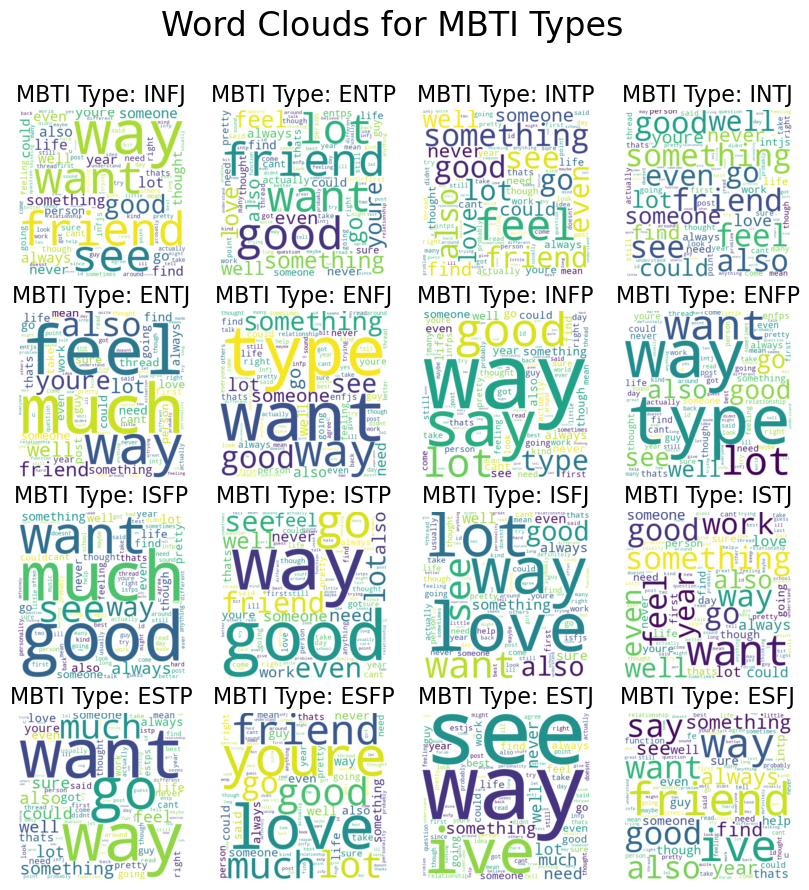

In [108]:
common_words = get_wordCloud_unigrams(df, common_words_dict, n=100)

fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle('Word Clouds for MBTI Types', fontsize=24)

axes = axes.flatten()

# Word Cloud
for i, (mbti, words) in enumerate(common_words.items()):
    wordcloud = WordCloud(width=400, height=400, background_color='white').generate_from_frequencies(words)

    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(f'MBTI Type: {mbti}', fontsize=16)

plt.show()

#### Observation for Unigrams
1. Common Words Across Types: Words like “way,” “friend,” “want,” and “love” are universally prevalent.


2. **Extroverts vs. Introverts:**
- Extroverts: Action-oriented words (e.g., “go,” “love”) indicating a focus on social activities.
- Introverts: Reflective words (e.g., “see,” “something”) suggesting introspection.
3. **Sensing vs. Intuitive:**
- Sensing: Practical words (e.g., “good,” “much”).
- Intuitive: Abstract words (e.g., “see,” “something”).
4. **Feeling vs. Thinking:**
- Feeling: Emotion and relationship-focused words (e.g., “feel,” “love”).
- Thinking: Work-related words (e.g., “work”).
5. **Judging vs. Perceiving:**
- Judging: Goal-oriented words (e.g., “want,” “way”).
- Perceiving: Spontaneous words (e.g., “go,” “much”).


### 1.1.3.4: Word Cloud - Bigrams

In [109]:
def get_ngrams(tokens, n):
    return [' '.join(ng) for ng in ngrams(tokens, n)]

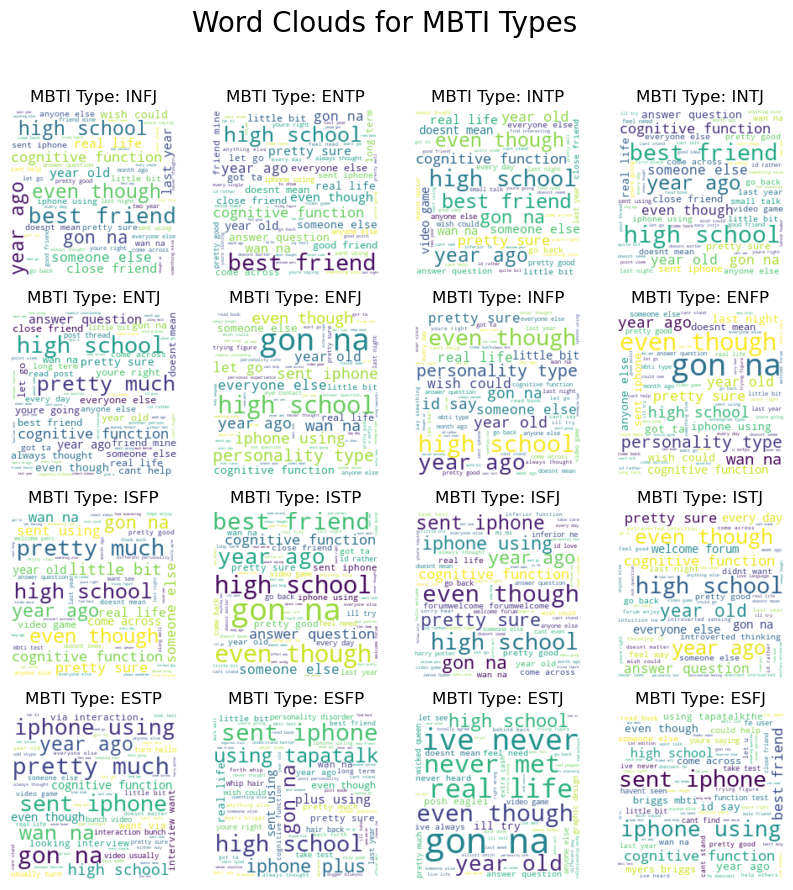

In [110]:
def get_wordCloud_bigrams(df, common_words_dict, n=100):
    mbti_terms = {}
    for mbti in df['type'].unique():
        mbti_posts = df[df['type'] == mbti]['cleaned_posts']
        all_posts = ' '.join(mbti_posts)
        comm_words = common_words_dict[mbti]
        tokens = remove_comm_words(all_posts, comm_words)
        bigrams = get_ngrams(tokens, 2)
        term_count = Counter(bigrams)
        top_terms = term_count.most_common(n)
        mbti_terms[mbti] = {term: count for term, count in top_terms}
    return mbti_terms

common_phrase = get_wordCloud_bigrams(df, common_words_dict, n=100)

fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle('Word Clouds for MBTI Types', fontsize=20)

axes = axes.flatten()

# Word Cloud
for i, (mbti, words) in enumerate(common_phrase.items()):
    wordcloud = WordCloud(width=200, height=200, background_color='white').generate_from_frequencies(words)

    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(f'MBTI Type: {mbti}', fontsize=12)

plt.show()

#### Obervation from Bigrams:
1. Common Phrases Across Types: “High school,” “year ago,” “even though,” “real life,” “best friend,” and “pretty much” dominate, suggesting reflections on past experiences and relationships.

2. **Extroverts vs. Introverts:**
- Extroverts: Future/present-oriented phrases (e.g., “gon na,” “real life”).
- Introverts: Past-oriented phrases (e.g., “high school,” “year ago”).
3. **Sensing vs. Intuitive:**
- Sensing: Real-world interaction phrases (e.g., “real life,” “sent iphone”).
- Intuitive: Less distinct differences observed.
4. **Feeling vs. Thinking:**
- Thinking: Intellectual phrases (e.g., “cognitive function,” “answer question”).
- Feeling: No major distinctions observed.
5. **Judging vs. Perceiving:**
- Judging: Past-focused phrases (e.g., “high school”).
- Perceiving: Future-focused phrases (e.g., “gon na”).

### 1.1.3.5: Sentiment analysis

#### Calculate sentiment scores 

In [113]:
sent_analyser = SentimentIntensityAnalyzer()

# Function to get all sentiment scores
def get_sentiment_scores(text):
    scores = sent_analyser.polarity_scores(text)
    return pd.Series({
        'compound': scores['compound'],
        'positive': scores['pos'],
        'negative': scores['neg'],
        'neutral': scores['neu']
    })

df[['compound', 'positive', 'negative', 'neutral']] = df['cleaned_posts'].apply(get_sentiment_scores)

# Groups data by MBTI type and calculates the mean positive, negative, and neutral sentiment scores.
avg_scores = df.groupby('type')[['positive', 'negative', 'neutral']].mean()
print("Average Positive, Negative, and Neutral Scores:")
print(avg_scores)

Average Positive, Negative, and Neutral Scores:
      positive  negative   neutral
type                              
ENFJ  0.268437  0.113053  0.618458
ENFP  0.260961  0.112767  0.626239
ENTJ  0.225069  0.120277  0.654641
ENTP  0.223889  0.121232  0.654844
ESFJ  0.251667  0.104381  0.643810
ESFP  0.229604  0.118083  0.652292
ESTJ  0.229000  0.117026  0.653897
ESTP  0.229326  0.119404  0.651303
INFJ  0.240383  0.115988  0.643619
INFP  0.241831  0.121941  0.635678
INTJ  0.218284  0.119985  0.661744
INTP  0.213365  0.123235  0.663414
ISFJ  0.247277  0.111066  0.641639
ISFP  0.245690  0.112915  0.641439
ISTJ  0.223746  0.112951  0.663293
ISTP  0.213389  0.127596  0.659015


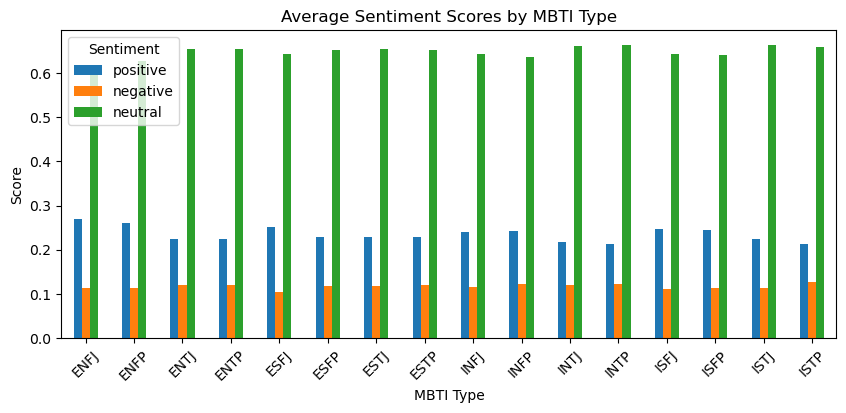

In [114]:
# Bar chart visualization highlights the sentiment tendencies of each MBTI type.
avg_scores.plot(kind='bar', figsize=(10, 4))
plt.title('Average Sentiment Scores by MBTI Type')
plt.xlabel('MBTI Type')
plt.ylabel('Score')
plt.legend(title='Sentiment')
plt.xticks(rotation=45)
plt.show()

**Average Sentiment Scores**

1. Positive Sentiment:
- Types like ENFJ, ENFP, and ISFJ exhibit higher positive sentiment.
- Reflects emotional and relationship-oriented traits of Feeling types.
2. Negative Sentiment:
- Types like ISTP and INFP have higher negative sentiment.
- Suggests introspection or reflective tendencies common in Introverted and Thinking types.
3. Neutral Sentiment:
- INTJ and INTP show the highest neutral sentiment, indicating a logical or detached tone in their posts.
- Extroverted types (ESFJ, ENFP) have slightly lower neutrality, likely due to emotional expression.

#### Sentiment Ratio (Positive to Negative)

In [116]:
# Calculates the ratio of positive to negative sentiment (positive / negative) for each MBTI type.
avg_scores['sentiment_ratio'] = avg_scores['positive'] / avg_scores['negative']
print("Sentiment Ratio (Positive to Negative):")
print(avg_scores['sentiment_ratio'].sort_values(ascending=False))

Sentiment Ratio (Positive to Negative):
type
ESFJ    2.411040
ENFJ    2.374441
ENFP    2.314157
ISFJ    2.226393
ISFP    2.175882
INFJ    2.072486
INFP    1.983187
ISTJ    1.980911
ESTJ    1.956836
ESFP    1.944425
ESTP    1.920580
ENTJ    1.871257
ENTP    1.846780
INTJ    1.819257
INTP    1.731372
ISTP    1.672372
Name: sentiment_ratio, dtype: float64


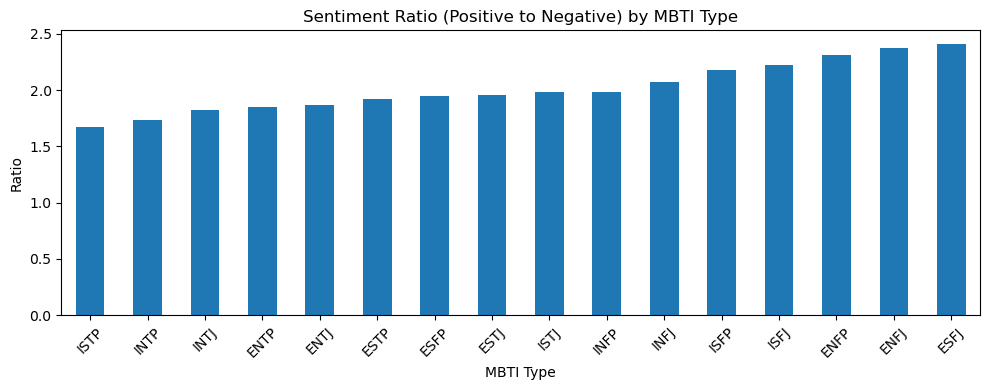

In [117]:
# Bar chart visualization highlights the sentiment tendencies of each MBTI type.
avg_scores['sentiment_ratio'].sort_values().plot(kind='bar', figsize=(10, 4))
plt.title('Sentiment Ratio (Positive to Negative) by MBTI Type')
plt.xlabel('MBTI Type')
plt.ylabel('Ratio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Sentiment Ratio**

1. Highest Sentiment Ratio:
- ESFJ, ENFJ, ENFP: Tend to express more positive sentiment compared to negative, aligning with their empathetic and emotionally driven traits.
2. Lowest Sentiment Ratio:
- ISTP, INTP: Exhibit a more balanced or slightly negative tone, consistent with analytical and less emotionally expressive traits.

#### Distribution of Post Length for each Personality Type

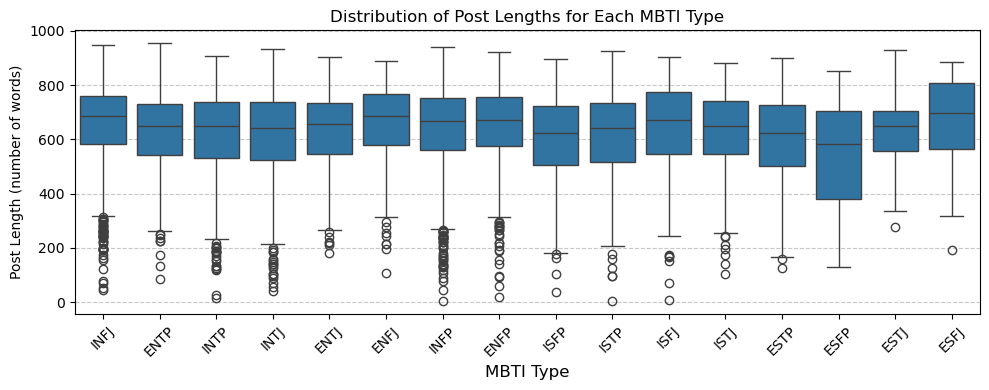

In [90]:
# Func to count words in a post
def count_words(posts):
    return sum(len(post.split()) for post in posts.split('|||'))

df['post_length'] = df['cleaned_posts'].apply(count_words)

plt.figure(figsize=(10, 4))
sns.boxplot(x='type', y='post_length', data=df)

plt.title('Distribution of Post Lengths for Each MBTI Type', fontsize=12)
plt.xlabel('MBTI Type', fontsize=12)
plt.ylabel('Post Length (number of words)', fontsize=10)
plt.xticks(rotation=45)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

#### Observation from Distribution
1. **Overall Trend:**
- Most MBTI types write posts averaging 600–700 words.
- The range of word counts is consistent across most types, except for ESFP, which exhibits significantly greater variability.
2. **Longer Posts:**
- Types like ESFJ, ISFJ, and INFJ tend to write longer posts, potentially reflecting their detail-oriented or expressive nature.
3. **Shorter Posts:**
- Types like ESTP and ISTP write shorter posts, aligning with their pragmatic and action-focused tendencies.
4. **Outliers:**
- Certain types, such as INFJ, INTP, INFP, and ENFP, have a wide range of post lengths with noticeable outliers, suggesting that while trends can be generalized, individual differences within each type are significant.

## 1.2: Data Splitting

### 1.2.1: Development-Test Split (80/20):
- Splits the full dataset into a development set (80%) and a test set (20%) using stratified sampling based on MBTI types.
- Maintains class distribution in both sets, as recommended for imbalanced datasets ￼.

In [ ]:
# Separate features and target
X = df['cleaned_posts']
y = df['encoded_type']

# Split into Development and Test Sets (80/20 split)
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### 1.2.2: Training-Validation Split (75/25 of Development Set):
- Further splits the development set into a training set (75%) and a validation set (25%) using stratified sampling.
- This partition allows for hyperparameter tuning on the validation set without affecting the test set, as per class guidelines.

In [8]:
# Split Development Set into Training and Validation Sets
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.25, stratify=y_dev, random_state=42)

### 1.2.3: Class Distribution Check:
- Prints class distribution for each split to confirm successful stratification, ensuring that each subset reflects the original data’s class proportions

In [9]:
print("Data split sizes:")
print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")

Data split sizes:
Training set: 5205 samples
Validation set: 1735 samples
Test set: 1735 samples


In [10]:
# Display the shape of the original splitted data
print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (5205,)
Validation set shape: (1735,)
Test set shape: (1735,)


## 1.3: Feature Engineering

### 1.3.1: TF-IDF Vectorization:
- Convert cleaned text into numerical features, using TF-IDF to capture the importance of words relative to each personality type across the dataset. Limit to the top 5000 features for efficiency.

In [11]:
# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

# Fit the vectorizer on the training data and transform the training data into TF-IDF features
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

- TFIDF shape

In [12]:
print(f"TF-IDF Training set shape: {X_train_tfidf.shape}")
print(f"TF-IDF Validation set shape: {X_val_tfidf.shape}")
print(f"TF-IDF Test set shape: {X_test_tfidf.shape}")

TF-IDF Training set shape: (5205, 5000)
TF-IDF Validation set shape: (1735, 5000)
TF-IDF Test set shape: (1735, 5000)


### 1.3.2: Elastic Net feature selection and regularization
- Elastic Net to identify and retain the most relevant words for distinguishing between personality types, reducing noise and focusing on important features.

In [13]:
# Initialize Elastic Net with cross-validation
elastic_net = ElasticNetCV(l1_ratio=[0.1, 0.5, 0.9], alphas=[0.001, 0.01, 0.1, 1.0, 10.0], cv=5, random_state=42)

# Use Elastic Net for feature selection on TF-IDF transformed training data
select_model = SelectFromModel(estimator=elastic_net, threshold='mean')

# Fit on training data to determine the selected features
select_model.fit(X_train_tfidf, y_train)

# Transform training, validation, and test data to keep only selected features
X_train_selected = select_model.transform(X_train_tfidf)
X_val_selected = select_model.transform(X_val_tfidf)
X_test_selected = select_model.transform(X_test_tfidf)

- Elastic Net shape

In [14]:
print("Reduced Training set shape:", X_train_selected.shape)
print("Reduced Validation set shape:", X_val_selected.shape)
print("Reduced Test set shape:", X_test_selected.shape)

Reduced Training set shape: (5205, 443)
Reduced Validation set shape: (1735, 443)
Reduced Test set shape: (1735, 443)


### After the TF-IDF vectorization, the current dataset is both sparse and imbalanced

## 1.4: Class Balancing techniques

### 1.4.1: Handling data sparsity with feature selection

- Variance-Based Filtering: Remove features with minimal variance across samples, further refining the feature set.

In [15]:
# Set a variance threshold to filter out low-variance features in Elastic-Net matrix
variance_filter = VarianceThreshold(threshold=0.0001)

# Fit the variance threshold on the balanced training set and transform the training, validation, and test sets
X_train_var = variance_filter.fit_transform(X_train_selected)
X_val_var = variance_filter.transform(X_val_selected)
X_test_var = variance_filter.transform(X_test_selected)

In [16]:
print(f"Variance-Based Training set shape: {X_train_var.shape}")
print(f"Variance-Based Validation set shape: {X_val_var.shape}")
print(f"Variance-Based Test set shape: {X_test_var.shape}")

Variance-Based Training set shape: (5205, 420)
Variance-Based Validation set shape: (1735, 420)
Variance-Based Test set shape: (1735, 420)


### 1.4.2: Handling data sparsity with feature transformation

- PCA: Apply PCA to condense features while retaining 95% of the data’s variance, creating a compact and information-rich feature space.

In [17]:
# Initialize PCA to retain 95% of variance
pca = PCA(n_components=0.95, random_state=42)

# Fit PCA on the balanced training set and transform the training, validation, and test sets
X_train_pca = pca.fit_transform(X_train_var.toarray())
X_val_pca = pca.transform(X_val_var.toarray())
X_test_pca = pca.transform(X_test_var.toarray())

In [18]:
print(f"PCA Training set shape: {X_train_pca.shape}")
print(f"PCA Validation set shape: {X_val_pca.shape}")
print(f"PCA Test set shape: {X_test_pca.shape}")

PCA Training set shape: (5205, 340)
PCA Validation set shape: (1735, 340)
PCA Test set shape: (1735, 340)


### 1.4.3: Handling data imbalance by SMOTE

- Use SMOTE to balance the training dataset across personality types by generating synthetic samples, ensuring that models don’t become biased towards majority classes.

In [19]:
# Apply SMOTE to balance the training set
smote = SMOTE(random_state=42)
X_train_clean, y_train_clean = smote.fit_resample(X_train_pca, y_train)

In [20]:
print("Class distribution in the balanced training set:")
print(pd.Series(y_train_clean).value_counts())

Class distribution in the balanced training set:
encoded_type
9     1099
2     1099
8     1099
11    1099
1     1099
10    1099
14    1099
13    1099
3     1099
15    1099
6     1099
12    1099
0     1099
7     1099
4     1099
5     1099
Name: count, dtype: int64


### Define variables for modeling

- Independent Variable

In [ ]:
# Training features
X_train_clean.shape

(17584, 340)

In [ ]:
# Validation features
X_val_pca.shape

(1735, 340)

In [ ]:
# Test Features
X_test_pca.shape

(1735, 340)

- Dependent Variable

In [ ]:
# Training labels
y_train_clean.shape

(17584,)

In [126]:
# Validation Label
y_val.shape

(1735,)

In [127]:
# Test label
y_test.shape

(1735,)

# 2: Model training

## 2.1 Model Selection

### 2.1.1: KNN classifier

In [ ]:
# Fit the KNN model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_clean, y_train_clean)

# Predict using the KNN model
y_pred_knn = knn.predict(X_test_pca)

# Calculate metrics
accuracy_knn = accuracy_score(y_test, y_pred_knn)
recall_knn = recall_score(y_test, y_pred_knn, average='weighted')
precision_knn = precision_score(y_test, y_pred_knn, average='weighted') 
f1_knn = f1_score(y_test, y_pred_knn, average='weighted')

In [27]:
# Display metrics
print(f"KNN Model Accuracy: {accuracy_knn:.6f}")
print(f"KNN Model Recall: {recall_knn:.6f}")
print(f"KNN Model Precision: {precision_knn}")
print(f"KNN Model F1-Score: {f1_knn:.6f}")

KNN Model Accuracy: 0.277233
KNN Model Recall: 0.277233
KNN Model Precision: 0.49529201246229143
KNN Model F1-Score: 0.270472


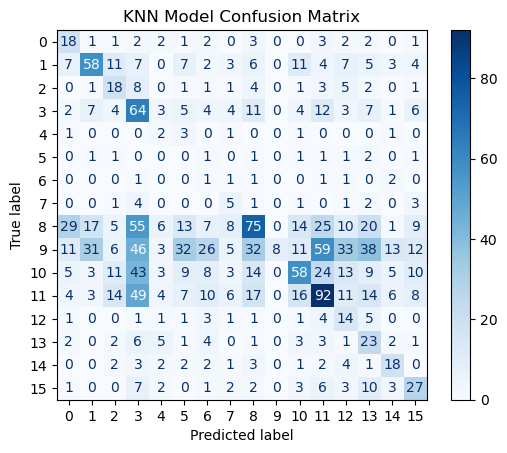

In [28]:
knn_confusion_matrix = confusion_matrix(y_test, y_pred_knn)
disp_knn = ConfusionMatrixDisplay(confusion_matrix=knn_confusion_matrix, display_labels=knn.classes_)
disp_knn.plot(cmap="Blues", values_format="d")
plt.title("KNN Model Confusion Matrix")
plt.show()

In [31]:
print(f"KNN - Accuracy: {accuracy_knn:.4f}")
print("Classification Report for KNN:\n", classification_report(y_test, y_pred_knn))

KNN - Accuracy: 0.2772
Classification Report for KNN:
               precision    recall  f1-score   support

           0       0.22      0.47      0.30        38
           1       0.48      0.43      0.45       135
           2       0.24      0.39      0.30        46
           3       0.22      0.47      0.30       137
           4       0.06      0.22      0.10         9
           5       0.00      0.00      0.00        10
           6       0.01      0.12      0.02         8
           7       0.12      0.28      0.17        18
           8       0.44      0.26      0.32       294
           9       1.00      0.02      0.04       366
          10       0.46      0.27      0.34       218
          11       0.38      0.35      0.37       261
          12       0.13      0.42      0.20        33
          13       0.16      0.43      0.24        54
          14       0.33      0.44      0.37        41
          15       0.33      0.40      0.36        67

    accuracy             

### 2.1.2: Decision Tree Classifier

In [ ]:
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train_clean, y_train_clean)
y_pred_tree = tree.predict(X_test_pca)

accuracy_tree = accuracy_score(y_test, y_pred_tree)
recall_tree = recall_score(y_test, y_pred_tree, average='weighted')    
precision_tree = precision_score(y_test, y_pred_tree, average='weighted')  
f1_tree = f1_score(y_test, y_pred_tree, average='weighted')
conf_matrix_tree = confusion_matrix(y_test, y_pred_tree)

In [33]:
# Display metrics
print(f"Accuracy: {accuracy_tree}")
print(f"Recall: {recall_tree}")
print(f"Precision: {precision_tree}")
print(f"F1-Score: {f1_tree}")

Accuracy: 0.33544668587896254
Recall: 0.33544668587896254
Precision: 0.38551667270724765
F1-Score: 0.35480892001542547


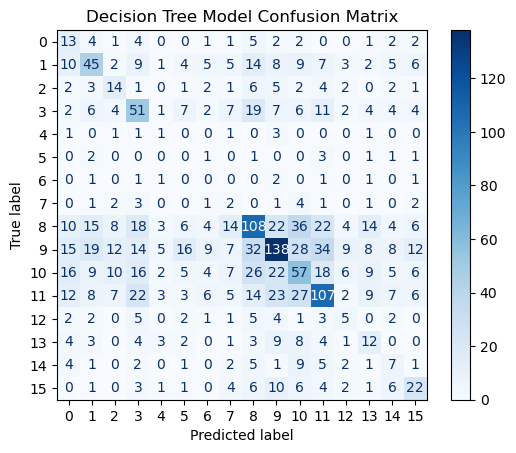

In [34]:
conf_matrix_tree = confusion_matrix(y_test, y_pred_tree)
disp_tree = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_tree, display_labels=tree.classes_)
disp_tree.plot(cmap="Blues", values_format="d")
plt.title("Decision Tree Model Confusion Matrix")
plt.show()

In [35]:
print(f"Decision Tree - Accuracy: {accuracy_tree:.4f}")
print("Classification Report for Decision Tree:\n", classification_report(y_test, y_pred_tree))

Decision Tree - Accuracy: 0.3354
Classification Report for Decision Tree:
               precision    recall  f1-score   support

           0       0.14      0.34      0.20        38
           1       0.38      0.33      0.35       135
           2       0.23      0.30      0.26        46
           3       0.33      0.37      0.35       137
           4       0.05      0.11      0.07         9
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00         8
           7       0.03      0.11      0.05        18
           8       0.44      0.37      0.40       294
           9       0.54      0.38      0.44       366
          10       0.29      0.26      0.28       218
          11       0.48      0.41      0.44       261
          12       0.13      0.15      0.14        33
          13       0.18      0.22      0.20        54
          14       0.13      0.17      0.15        41
          15       0.31      0.33      0.32        67

    a

### 2.1.3: Logistic regression

In [36]:
log_reg = LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=42)
log_reg.fit(X_train_clean, y_train_clean)
y_pred_log_reg = log_reg.predict(X_test_pca)

accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
recall_log_reg = recall_score(y_test, y_pred_log_reg, average='weighted')    
precision_log_reg = precision_score(y_test, y_pred_log_reg, average='weighted')
f1_log_reg = f1_score(y_test, y_pred_log_reg, average='weighted')
conf_matrix_log_reg = confusion_matrix(y_test, y_pred_log_reg)

In [37]:
print(f"Accuracy: {accuracy_log_reg}")
print(f"Recall: {recall_log_reg}")
print(f"Precision: {precision_log_reg}")
print(f"F1-Score: {f1_log_reg}")

Accuracy: 0.6126801152737752
Recall: 0.6126801152737752
Precision: 0.6658019536864404
F1-Score: 0.630901660739127


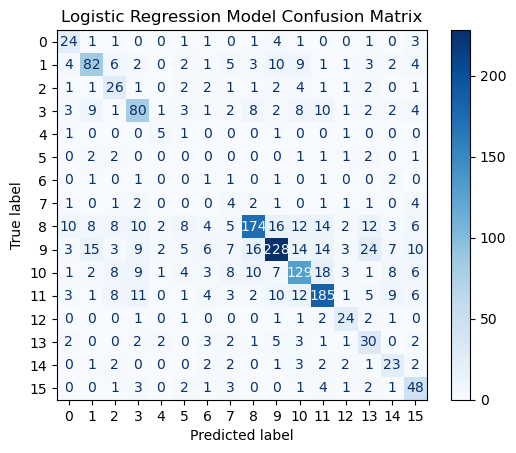

In [38]:
# Plot the confusion matrix
disp_log_reg = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_log_reg, display_labels=log_reg.classes_)
disp_log_reg.plot(cmap="Blues", values_format="d")
plt.title("Logistic Regression Model Confusion Matrix")
plt.show()

In [39]:
print(f"Logistic Regression - Accuracy: {accuracy_log_reg:.4f}")
print("Classification Report for Logistic Regression:\n", classification_report(y_test, y_pred_log_reg))

Logistic Regression - Accuracy: 0.6127
Classification Report for Logistic Regression:
               precision    recall  f1-score   support

           0       0.45      0.63      0.53        38
           1       0.67      0.61      0.64       135
           2       0.39      0.57      0.46        46
           3       0.61      0.58      0.60       137
           4       0.38      0.56      0.45         9
           5       0.00      0.00      0.00        10
           6       0.03      0.12      0.05         8
           7       0.09      0.22      0.13        18
           8       0.80      0.59      0.68       294
           9       0.79      0.62      0.70       366
          10       0.65      0.59      0.62       218
          11       0.73      0.71      0.72       261
          12       0.56      0.73      0.63        33
          13       0.34      0.56      0.42        54
          14       0.40      0.56      0.46        41
          15       0.49      0.72      0.59     

### 2.1.5: Random Forest

In [40]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_clean, y_train_clean)
y_pred_rf = rf.predict(X_test_pca)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf, average='weighted')   
precision_rf = precision_score(y_test, y_pred_rf, average='weighted')
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

/Users/jacksonzhao/miniconda3/envs/eods/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
print(f"Accuracy: {accuracy_rf}")
print(f"Recall: {recall_rf}")
print(f"Precision: {precision_rf}")
print(f"F1-Score: {f1_rf}")

Accuracy: 0.58328530259366
Recall: 0.58328530259366
Precision: 0.5760743315346717
F1-Score: 0.578472614252448


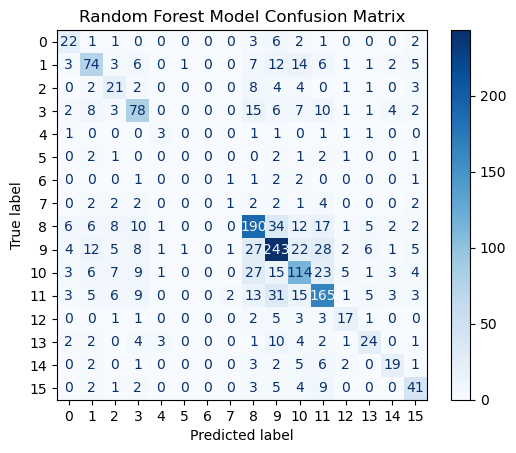

In [42]:
disp_rf = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_rf, display_labels=rf.classes_)
disp_rf.plot(cmap="Blues", values_format="d")
plt.title("Random Forest Model Confusion Matrix")
plt.show()

In [43]:
print(f"Random Forest - Accuracy: {accuracy_rf:.4f}")
print("Classification Report for Random Forest:\n", classification_report(y_test, y_pred_rf))

Random Forest - Accuracy: 0.5833
Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.48      0.58      0.52        38
           1       0.60      0.55      0.57       135
           2       0.36      0.46      0.40        46
           3       0.59      0.57      0.58       137
           4       0.33      0.33      0.33         9
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00         8
           7       0.20      0.06      0.09        18
           8       0.63      0.65      0.64       294
           9       0.64      0.66      0.65       366
          10       0.54      0.52      0.53       218
          11       0.60      0.63      0.61       261
          12       0.50      0.52      0.51        33
          13       0.52      0.44      0.48        54
          14       0.56      0.46      0.51        41
          15       0.56      0.61      0.59        67

    a

/Users/jacksonzhao/miniconda3/envs/eods/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jacksonzhao/miniconda3/envs/eods/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jacksonzhao/miniconda3/envs/eods/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

### 2.1.6: XGBoost Model

In [44]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb.fit(X_train_clean, y_train_clean)
y_pred_xgb = xgb.predict(X_test_pca)

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb, average='weighted')    
precision_xgb = precision_score(y_test, y_pred_xgb, average='weighted')
f1_xgb = f1_score(y_test, y_pred_xgb, average='weighted')
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)

/Users/jacksonzhao/miniconda3/envs/eods/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:10:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [45]:
print(f"Accuracy: {accuracy_xgb}")
print(f"Recall: {recall_xgb}")
print(f"Precision: {precision_xgb}")
print(f"F1-Score: {f1_xgb}")

Accuracy: 0.6219020172910663
Recall: 0.6219020172910663
Precision: 0.6129064364397634
F1-Score: 0.6161726750313699


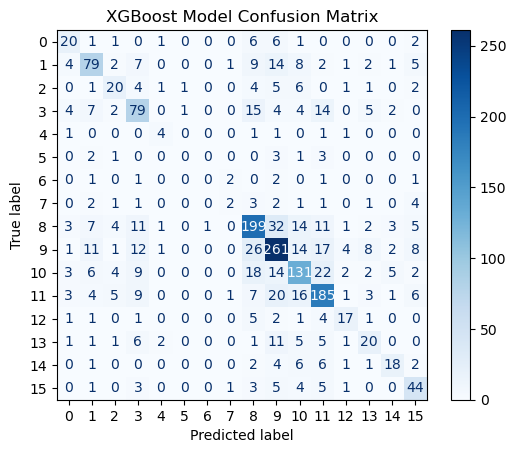

In [46]:
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_xgb, display_labels=xgb.classes_)
disp_xgb.plot(cmap="Blues", values_format="d")
plt.title("XGBoost Model Confusion Matrix")
plt.show()

In [47]:
print(f"XGBoost - Accuracy: {accuracy_xgb:.4f}")
print("Classification Report for XGBoost:\n", classification_report(y_test, y_pred_xgb))

XGBoost - Accuracy: 0.6219
Classification Report for XGBoost:
               precision    recall  f1-score   support

           0       0.49      0.53      0.51        38
           1       0.63      0.59      0.61       135
           2       0.48      0.43      0.45        46
           3       0.55      0.58      0.56       137
           4       0.40      0.44      0.42         9
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00         8
           7       0.29      0.11      0.16        18
           8       0.67      0.68      0.67       294
           9       0.68      0.71      0.69       366
          10       0.62      0.60      0.61       218
          11       0.67      0.71      0.69       261
          12       0.55      0.52      0.53        33
          13       0.43      0.37      0.40        54
          14       0.56      0.44      0.49        41
          15       0.54      0.66      0.59        67

    accuracy     

### 2.1.7: Adaboost Classifier

In [48]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators=50, random_state=42)
ada.fit(X_train_clean, y_train_clean)
y_pred_ada = ada.predict(X_test_pca)

accuracy_ada = accuracy_score(y_test, y_pred_ada)
recall_ada = recall_score(y_test, y_pred_ada, average='weighted')    
precision_ada = precision_score(y_test, y_pred_ada, average='weighted')
f1_ada = f1_score(y_test, y_pred_ada, average='weighted')
conf_matrix_ada = confusion_matrix(y_test, y_pred_ada)

In [49]:
print(f"Accuracy: {accuracy_ada}")
print(f"Recall: {recall_ada}")
print(f"Precision: {precision_ada}")
print(f"F1-Score: {f1_ada}")

Accuracy: 0.3579250720461095
Recall: 0.3579250720461095
Precision: 0.4532069590950188
F1-Score: 0.38802166921584813


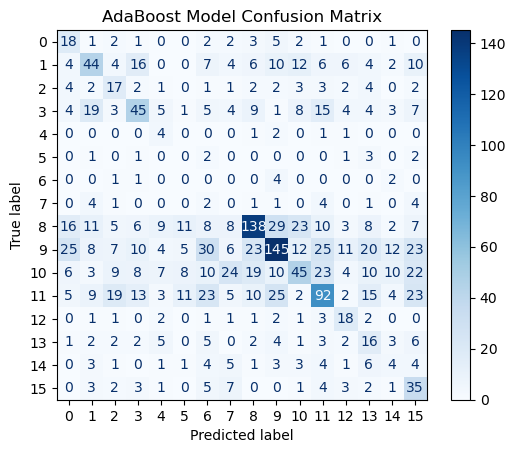

In [50]:
disp_ada = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_ada, display_labels=ada.classes_)
disp_ada.plot(cmap="Blues", values_format="d")
plt.title("AdaBoost Model Confusion Matrix")
plt.show()

In [51]:
print(f"AdaBoost - Accuracy: {accuracy_ada:.4f}")
print("Classification Report for AdaBoost:\n", classification_report(y_test, y_pred_ada))

AdaBoost - Accuracy: 0.3579
Classification Report for AdaBoost:
               precision    recall  f1-score   support

           0       0.22      0.47      0.30        38
           1       0.40      0.33      0.36       135
           2       0.23      0.37      0.28        46
           3       0.42      0.33      0.37       137
           4       0.10      0.44      0.16         9
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00         8
           7       0.00      0.00      0.00        18
           8       0.64      0.47      0.54       294
           9       0.60      0.40      0.48       366
          10       0.40      0.21      0.27       218
          11       0.47      0.35      0.40       261
          12       0.31      0.55      0.40        33
          13       0.17      0.30      0.21        54
          14       0.09      0.10      0.09        41
          15       0.24      0.52      0.33        67

    accuracy   

### 2.1.8: Kernel SVM

In [52]:
from sklearn.svm import SVC
kernel_svm = SVC(kernel='rbf', gamma='scale', random_state=42)
kernel_svm.fit(X_train_clean, y_train_clean)
y_pred_kernel_svm = kernel_svm.predict(X_test_pca)

accuracy_kernel_svm = accuracy_score(y_test, y_pred_kernel_svm)
recall_kernel_svm = recall_score(y_test, y_pred_kernel_svm, average='weighted')    
precision_kernel_svm = precision_score(y_test, y_pred_kernel_svm, average='weighted')
f1_kernel_svm = f1_score(y_test, y_pred_kernel_svm, average='weighted')
conf_matrix_kernel_svm = confusion_matrix(y_test, y_pred_kernel_svm)

/Users/jacksonzhao/miniconda3/envs/eods/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [53]:
print(f"Accuracy: {accuracy_kernel_svm}")
print(f"Recall: {recall_kernel_svm}")
print(f"Precision: {precision_kernel_svm}")
print(f"F1-Score: {f1_kernel_svm}")

Accuracy: 0.6299711815561959
Recall: 0.6299711815561959
Precision: 0.6291127455986567
F1-Score: 0.6212650542782366


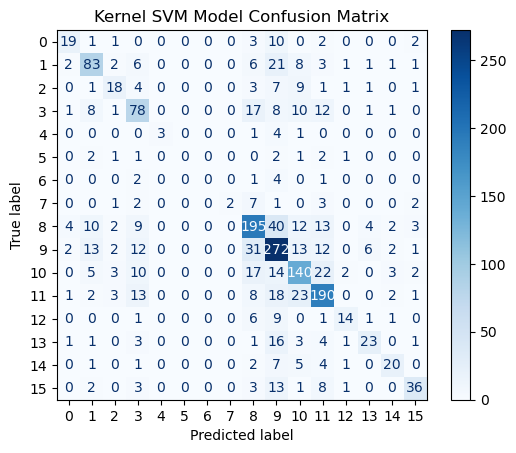

In [54]:
disp_kernel_svm = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_kernel_svm, display_labels=kernel_svm.classes_)
disp_kernel_svm.plot(cmap="Blues", values_format="d")
plt.title("Kernel SVM Model Confusion Matrix")
plt.show()

In [55]:
print(f"Kernel SVM - Accuracy: {accuracy_kernel_svm:.4f}")
print("Classification Report for Kernel SVM:\n", classification_report(y_test, y_pred_kernel_svm))

Kernel SVM - Accuracy: 0.6300
Classification Report for Kernel SVM:
               precision    recall  f1-score   support

           0       0.63      0.50      0.56        38
           1       0.64      0.61      0.63       135
           2       0.53      0.39      0.45        46
           3       0.54      0.57      0.55       137
           4       1.00      0.33      0.50         9
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00         8
           7       1.00      0.11      0.20        18
           8       0.65      0.66      0.66       294
           9       0.61      0.74      0.67       366
          10       0.62      0.64      0.63       218
          11       0.68      0.73      0.71       261
          12       0.64      0.42      0.51        33
          13       0.62      0.43      0.51        54
          14       0.62      0.49      0.55        41
          15       0.72      0.54      0.62        67

    accurac

/Users/jacksonzhao/miniconda3/envs/eods/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jacksonzhao/miniconda3/envs/eods/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jacksonzhao/miniconda3/envs/eods/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

### 2.1.9: Multi-layer Perceptron

In [56]:
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
mlp.fit(X_train_clean, y_train_clean)
y_pred_mlp = mlp.predict(X_test_pca)

accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
recall_mlp = recall_score(y_test, y_pred_mlp, average='weighted')    
precision_mlp = precision_score(y_test, y_pred_mlp, average='weighted')
f1_mlp = f1_score(y_test, y_pred_mlp, average='weighted')
conf_matrix_mlp = confusion_matrix(y_test, y_pred_mlp)

In [57]:
print(f"Accuracy: {accuracy_mlp}")
print(f"Recall: {recall_mlp}")
print(f"Precision: {precision_mlp}")
print(f"F1-Score: {f1_mlp}")

Accuracy: 0.5481268011527377
Recall: 0.5481268011527377
Precision: 0.5532925561844775
F1-Score: 0.5496239085734648


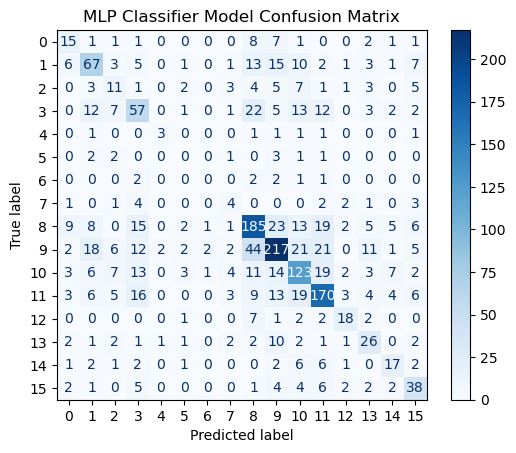

In [58]:
# Plot the confusion matrix
disp_mlp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_mlp, display_labels=mlp.classes_)
disp_mlp.plot(cmap="Blues", values_format="d")
plt.title("MLP Classifier Model Confusion Matrix")
plt.show()

In [59]:
print(f"MLP - Accuracy: {accuracy_mlp:.4f}")
print("Classification Report for MLP:\n", classification_report(y_test, y_pred_mlp))

MLP - Accuracy: 0.5481
Classification Report for MLP:
               precision    recall  f1-score   support

           0       0.34      0.39      0.37        38
           1       0.52      0.50      0.51       135
           2       0.24      0.24      0.24        46
           3       0.43      0.42      0.42       137
           4       0.50      0.33      0.40         9
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00         8
           7       0.18      0.22      0.20        18
           8       0.60      0.63      0.61       294
           9       0.67      0.59      0.63       366
          10       0.55      0.56      0.56       218
          11       0.64      0.65      0.65       261
          12       0.55      0.55      0.55        33
          13       0.40      0.48      0.44        54
          14       0.42      0.41      0.42        41
          15       0.47      0.57      0.52        67

    accuracy             

### Observation from modeling

**Models Based on Performance**
- Kernel SVM (Accuracy: 63.00%, F1-Score: 62.13%)
- XGBoost (Accuracy: 62.19%, F1-Score: 61.62%)
- Logistic Regression (Accuracy: 61.27%, F1-Score: 63.09%)
- Random Forest (Accuracy: 58.33%, F1-Score: 57.85%)
- Multi-Layer Perceptron (MLP) (Accuracy: 54.81%, F1-Score: 54.96%)
- Decision Tree (Accuracy: 33.54%, F1-Score: 35.48%)
- AdaBoost (Accuracy: 35.79%, F1-Score: 38.80%)
- KNN (Accuracy: 27.72%, F1-Score: 27.05%)

**Conclusion**
- The **Kernel SVM** stands out as the best-performing models based on both accuracy and F1-score

# 3. Tuning Parameter

## 3.1: Uninformed learning strategies - Random Search

In [129]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from scipy.stats import uniform

# Define the parameter distribution
param_distributions = {
    'C': uniform(0.1, 100),  # Regularization strength
    'gamma': uniform(0.01, 1),  # Kernel coefficient
    'kernel': ['rbf'],  # RBF kernel
}

# Initialize SVC
svc = SVC(random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=svc,
    param_distributions=param_distributions,
    n_iter=50,  # Number of parameter settings sampled
    scoring='accuracy',
    cv=5,  # 5-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1  # Use all available processors
)

# Fit RandomizedSearchCV
random_search.fit(X_train_clean, y_train_clean)

# Best parameters and score
print("Best Parameters from Random Search CV:", random_search.best_params_)
print("Best Accuracy from Random Search CV:", random_search.best_score_)

# Use the best model
best_model_random_search = random_search.best_estimator_

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END C=37.55401188473625, gamma=0.9607143064099162, kernel=rbf; total time=  16.6s
[CV] END C=73.2993941811405, gamma=0.6086584841970366, kernel=rbf; total time=  16.9s
[CV] END C=37.55401188473625, gamma=0.9607143064099162, kernel=rbf; total time=  18.1s
[CV] END C=73.2993941811405, gamma=0.6086584841970366, kernel=rbf; total time=  18.2s
[CV] END C=37.55401188473625, gamma=0.9607143064099162, kernel=rbf; total time=  18.9s
[CV] END C=73.2993941811405, gamma=0.6086584841970366, kernel=rbf; total time=  19.2s
[CV] END C=37.55401188473625, gamma=0.9607143064099162, kernel=rbf; total time=  20.2s
[CV] END C=37.55401188473625, gamma=0.9607143064099162, kernel=rbf; total time=  21.1s
[CV] END C=73.2993941811405, gamma=0.6086584841970366, kernel=rbf; total time=  19.4s
[CV] END C=73.2993941811405, gamma=0.6086584841970366, kernel=rbf; total time=  20.1s
[CV] END C=15.701864044243651, gamma=0.16599452033620266, kernel=rbf; tot

### Random Search CV Results

Best Parameters:
- C = 94.05
- gamma = 0.9048

Best Accuracy: **93.27%**

## 3.2: Informed Learning strategy - Bayesian Optimization

In [133]:
from skopt import BayesSearchCV
from skopt.space import Real

# Refine parameter space using Random Search results
param_space = {
    'C': Real(50, 100, prior='log-uniform'),  # Refined range for C
    'gamma': Real(0.5, 1, prior='log-uniform')  # Refined range for gamma
}

# Initialize Bayesian Optimization
bayes_search = BayesSearchCV(
    estimator=SVC(kernel='rbf', random_state=42),
    search_spaces=param_space,
    n_iter=30,  # Number of Bayesian iterations
    scoring='accuracy',
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,  # Use all available processors
    verbose=2,
    random_state=42
)

# Fit Bayesian Optimization
bayes_search.fit(X_train_clean, y_train_clean)

# Best parameters and score from Bayesian Optimization
print("Best Parameters from Bayesian Optimization:", bayes_search.best_params_)
print("Best Accuracy from Bayesian Optimization:", bayes_search.best_score_)

# Use the best model from Bayesian Optimization
best_model_bayes_search = bayes_search.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[CV] END ......C=66.43907805165023, gamma=0.8280132407707691; total time=  11.9s
[CV] END ......C=66.43907805165023, gamma=0.8280132407707691; total time=  12.6s
[CV] END ......C=66.43907805165023, gamma=0.8280132407707691; total time=  13.0s
[CV] END ......C=66.43907805165023, gamma=0.8280132407707691; total time=  13.4s
[CV] END ......C=66.43907805165023, gamma=0.8280132407707691; total time=  13.9s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END ......C=89.34063138495542, gamma=0.9223046504720644; total time=  11.3s
[CV] END ......C=89.34063138495542, gamma=0.9223046504720644; total time=  12.1s
[CV] END ......C=89.34063138495542, gamma=0.9223046504720644; total time=  12.4s
[CV] END ......C=89.34063138495542, gamma=0.9223046504720644; total time=  12.8s
[CV] END ......C=89.34063138495542, gamma=0.9223046504720644; total time=  13.0s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .......C=68.05780428903005, gamma=0.945220301905582; total time

In [146]:
# Extract the results from Bayesian Optimization
results = pd.DataFrame(bayes_search.cv_results_)

# Create a DataFrame with relevant columns
visualization_data = results[['param_C', 'param_gamma', 'mean_test_score']].copy()
visualization_data.columns = ['C', 'gamma', 'accuracy']
visualization_data.sort_values(by='accuracy', ascending=False, inplace=True)
print(visualization_data)

            C     gamma  accuracy
12      100.0       1.0  0.932896
1   89.340631  0.922305  0.932839
5   83.163825  0.958845  0.932782
7   72.870312  0.946064  0.932555
15  65.940013  0.959442  0.932498
2   68.057804   0.94522  0.932327
14  50.169428  0.997256  0.932043
8   96.961101  0.812602  0.931872
6   76.688351  0.855811  0.931872
17  51.536191  0.921549  0.931474
0   66.439078  0.828013  0.931304
9   50.125975  0.881376  0.931247
26  57.708777   0.85313  0.931190
23  67.300214  0.780689  0.930962
4   87.028114  0.677376  0.930906
16  83.696641  0.675246  0.930564
27  67.524685  0.733214  0.929939
22  67.399736  0.687217  0.929313
18  71.790942   0.67808  0.929256
20  57.109419  0.734858  0.929199
24  59.778961  0.642864  0.928688
3   87.806277  0.563259  0.928460
25   82.58172  0.525052  0.927664
13  50.039013  0.654746  0.927664
11  99.160678  0.500817  0.927607
21  50.697924  0.631643  0.927607
28  83.845505  0.508743  0.927436
29  67.508023  0.512672  0.926697
19  71.406837 

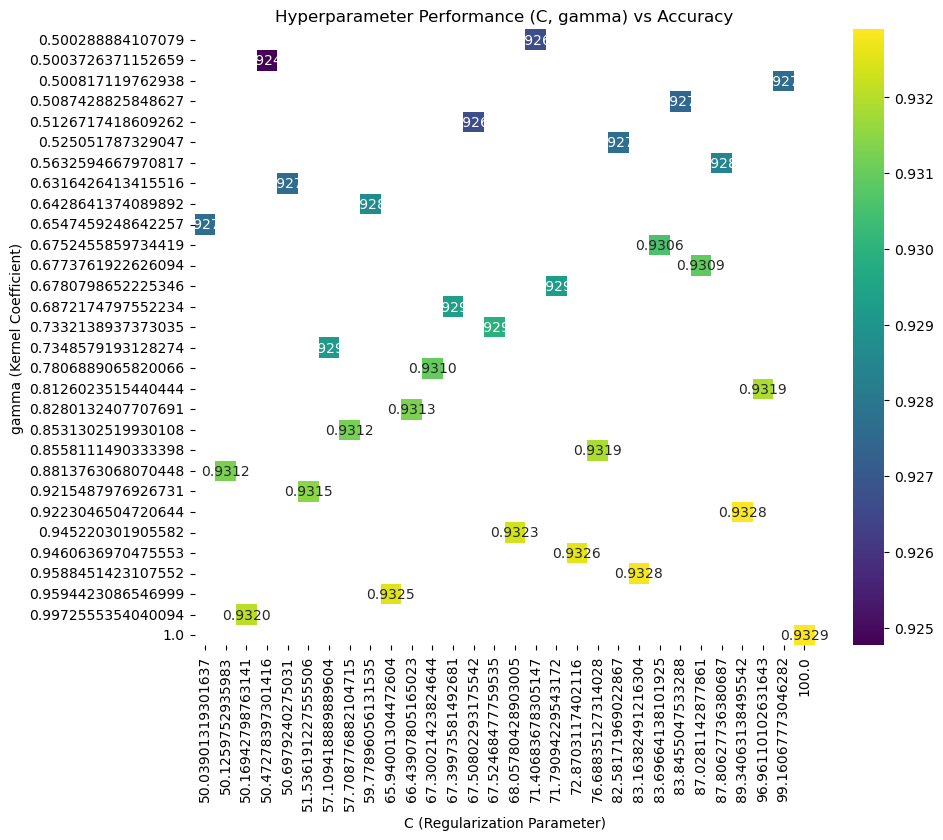

In [147]:
# Pivot the data to create a matrix suitable for a heatmap
heatmap_data = visualization_data.pivot(index='gamma', columns='C', values='accuracy')

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt='.4f', cmap='viridis', cbar=True)
plt.title('Hyperparameter Performance (C, gamma) vs Accuracy')
plt.xlabel('C (Regularization Parameter)')
plt.ylabel('gamma (Kernel Coefficient)')
plt.show()

#### Best Parameters from Bayesian Optimization

Best hyperparameter
- C = 100.0:
- gamma = 1.0:

Best Accuracy: **93.29%**

## 3.2: Use best tunned parameter to test whole labels
- To prevent overfitting, we won't use C=100 and gamma = 1 to apply to the Kernel SVM model.
1. Balancing Regularization (C):
- Higher values of C reduce regularization, allowing the model to fit the training data better, but this risks overfitting.
- Instead of choosing the highest C ( 100 ), a slightly lower value, such as  80 - 90 , balances flexibility and generalization.
2. Restricting Kernel Complexity (gamma):
- Higher gamma values fit data more tightly, which can lead to overfitting.
- Instead of choosing the highest value ( 1.0 ), a slightly lower value, such as  0.8 - 0.9 , maintains performance while reducing the risk of overfitting.

#### Hyperparameters selection
- C = 87.8: 
- gamma = 0.83

In [149]:
# Train the model with the chosen parameters
final_svm = SVC(kernel='rbf', C=87.8, gamma=0.83, random_state=42)
final_svm.fit(X_train_clean, y_train_clean)

# Predict on the test set
y_pred_final = final_svm.predict(X_test_pca)

# Evaluate the model
accuracy_final = accuracy_score(y_test, y_pred_final)
recall_final = recall_score(y_test, y_pred_final, average='weighted')
precision_final = precision_score(y_test, y_pred_final, average='weighted')
f1_final = f1_score(y_test, y_pred_final, average='weighted')
conf_matrix_final = confusion_matrix(y_test, y_pred_final)

# Display results
print(f"Final Model Test Accuracy: {accuracy_final}")
print(f"Final Model Test Recall: {recall_final}")
print(f"Final Model Test Precision: {precision_final}")
print(f"Final Model Test F1-Score: {f1_final}")

Final Model Test Accuracy: 0.5798270893371757
Final Model Test Recall: 0.5798270893371757
Final Model Test Precision: 0.5784707581420631
Final Model Test F1-Score: 0.5781196342072337


In [ ]:
# Generate the classification report
report_final = classification_report(y_test, y_pred_final, target_names=label_encoder.classes_)

# Print the classification report
print("Classification Report for Final SVM Model:")
print(report_final)

Classification Report for Final SVM Model:
              precision    recall  f1-score   support

        ENFJ       0.44      0.47      0.46        38
        ENFP       0.55      0.58      0.57       135
        ENTJ       0.43      0.43      0.43        46
        ENTP       0.49      0.53      0.51       137
        ESFJ       0.44      0.44      0.44         9
        ESFP       0.00      0.00      0.00        10
        ESTJ       0.00      0.00      0.00         8
        ESTP       0.33      0.28      0.30        18
        INFJ       0.60      0.67      0.64       294
        INFP       0.65      0.62      0.63       366
        INTJ       0.54      0.58      0.56       218
        INTP       0.66      0.61      0.63       261
        ISFJ       0.57      0.52      0.54        33
        ISFP       0.49      0.48      0.49        54
        ISTJ       0.59      0.49      0.53        41
        ISTP       0.61      0.52      0.56        67

    accuracy                         

## 3.3: Save to the output path

# 4. Extract Feature Importance

## 4.1: feature balancing

In [16]:
# Balancing data by SMOTE
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(X)
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_tfidf, y)

In [17]:
# Extract the models with best parameter
filename = 'output/best_model_logistic_regression.pkl'
with open(filename, 'rb') as file:
    model = pickle.load(file)

## 4.2: label manipulation

In [18]:
# set up mapping between label indices and label names
coef = model.coef_

# mapping labels to names
map_label = {}
for key, val in label_mapping.items():
  map_label[val] = key

## 4.3 Visualization of feature importance

[nltk_data] Downloading package words to
[nltk_data]     /Users/jacksonzhao/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


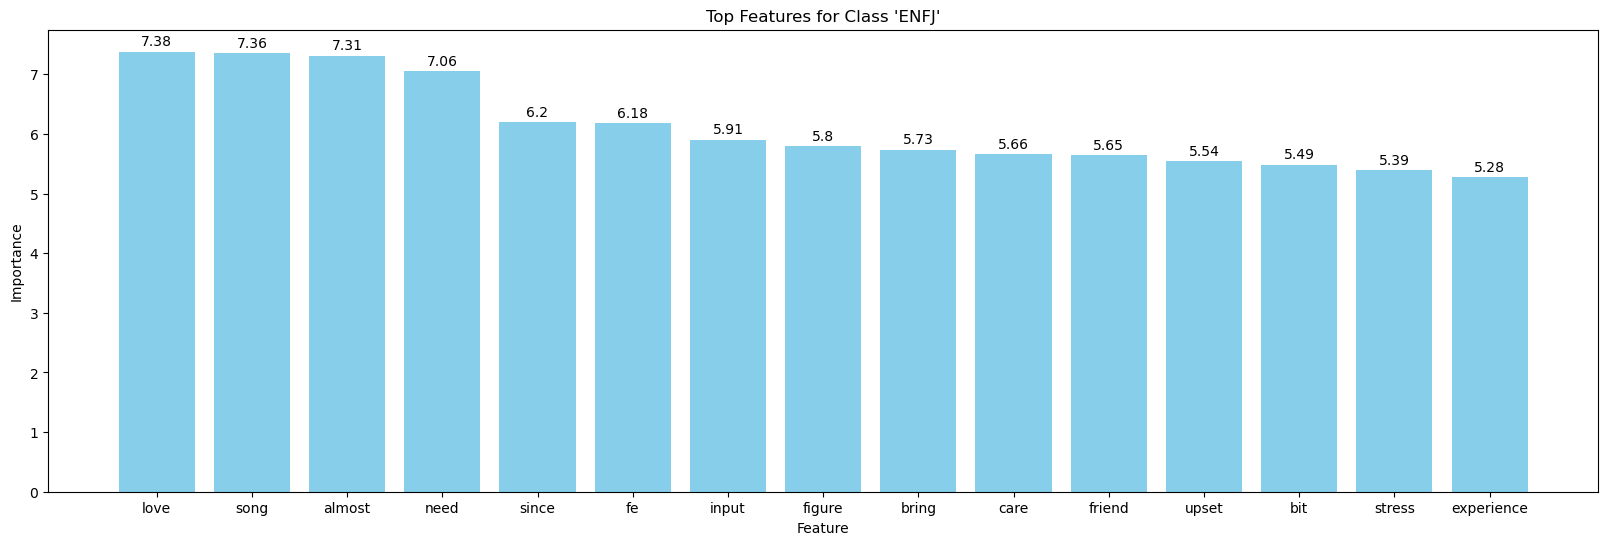

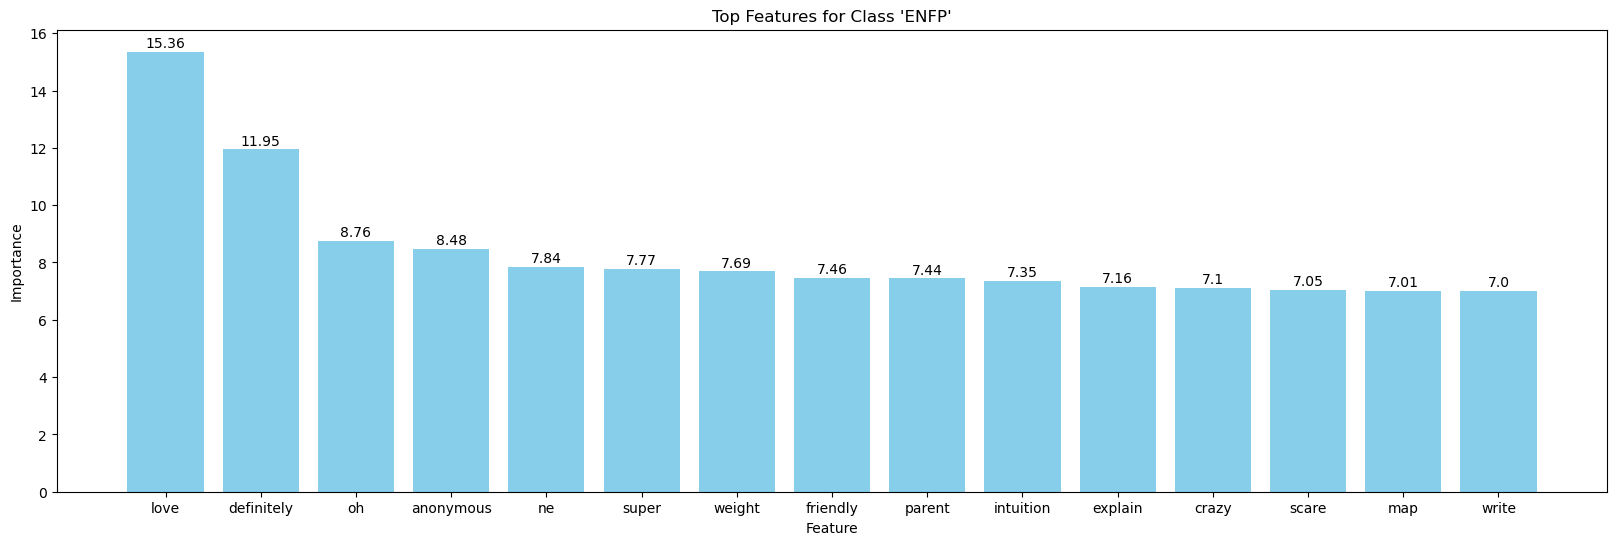

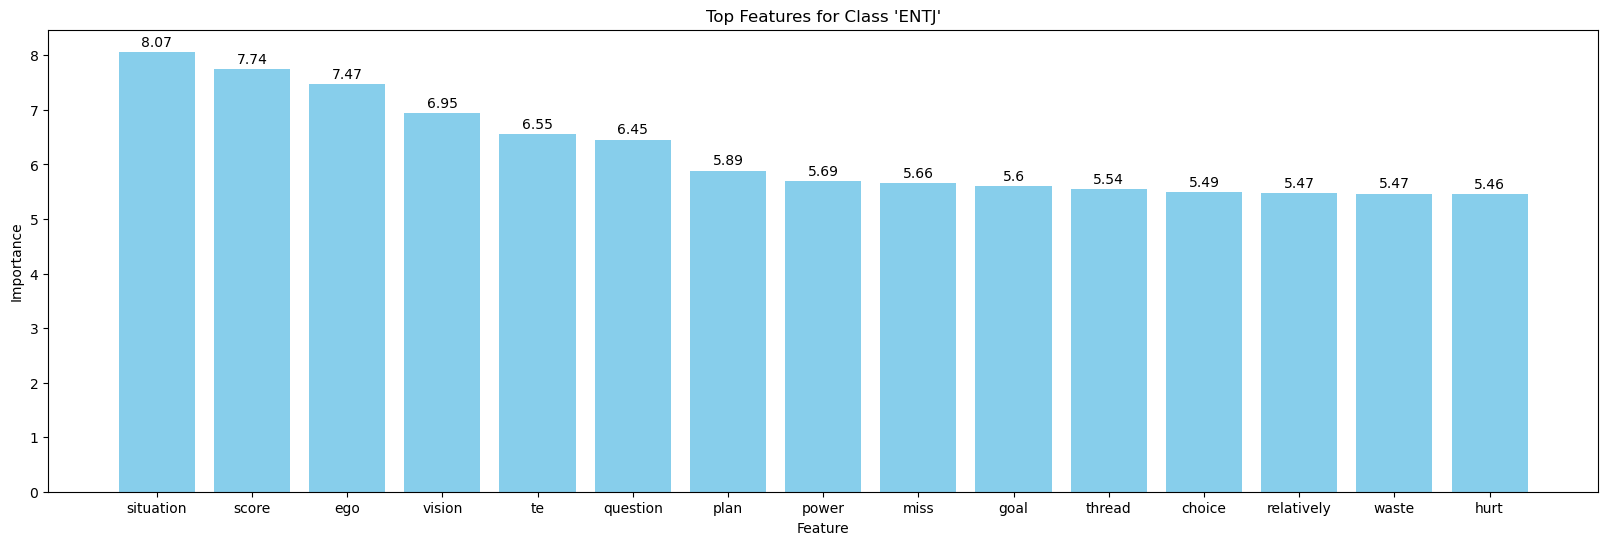

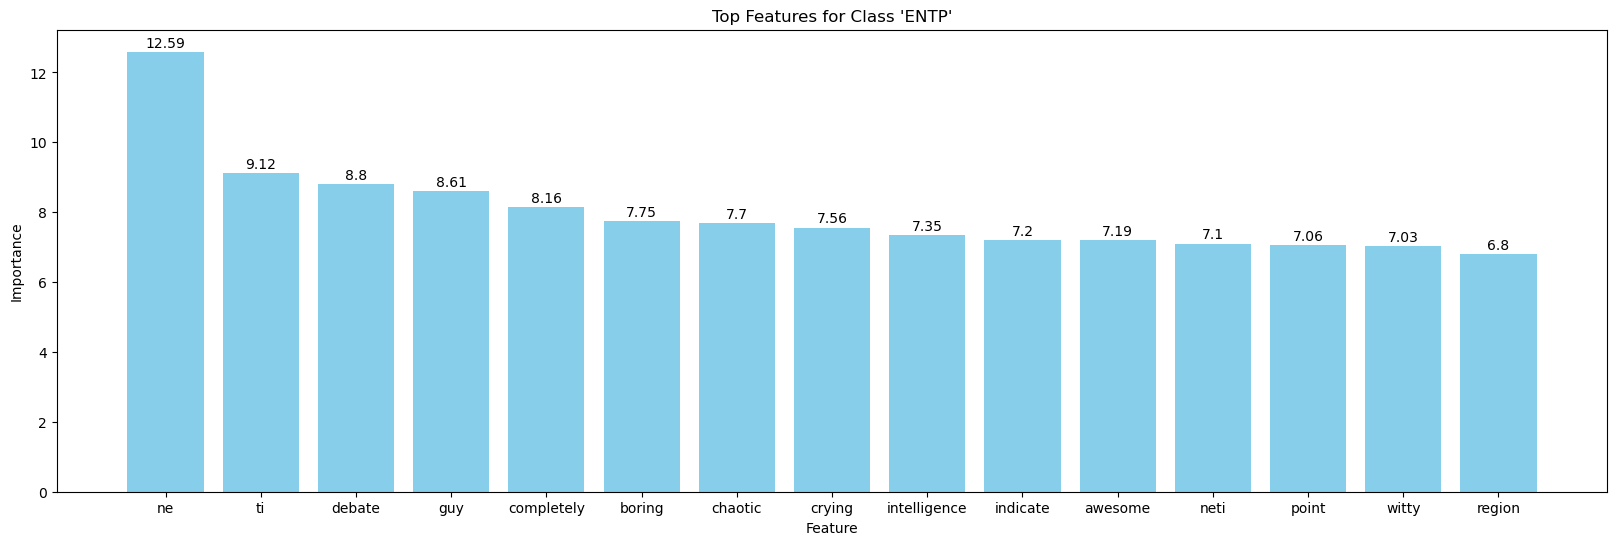

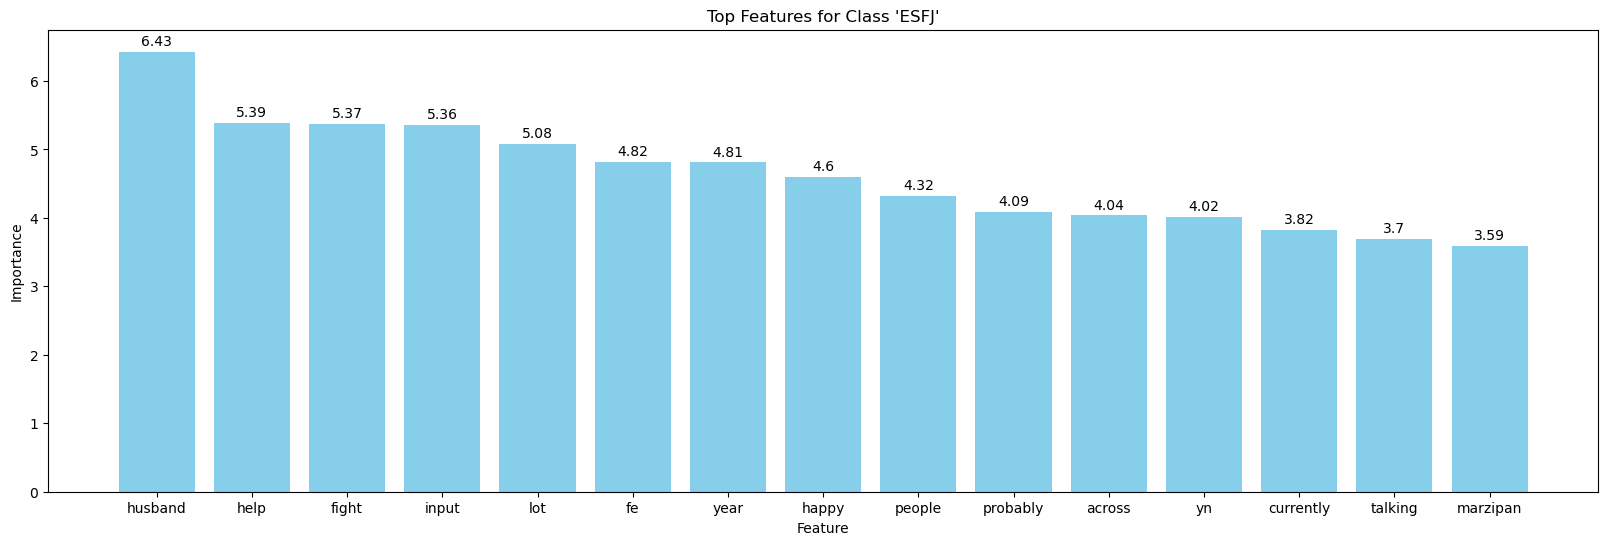

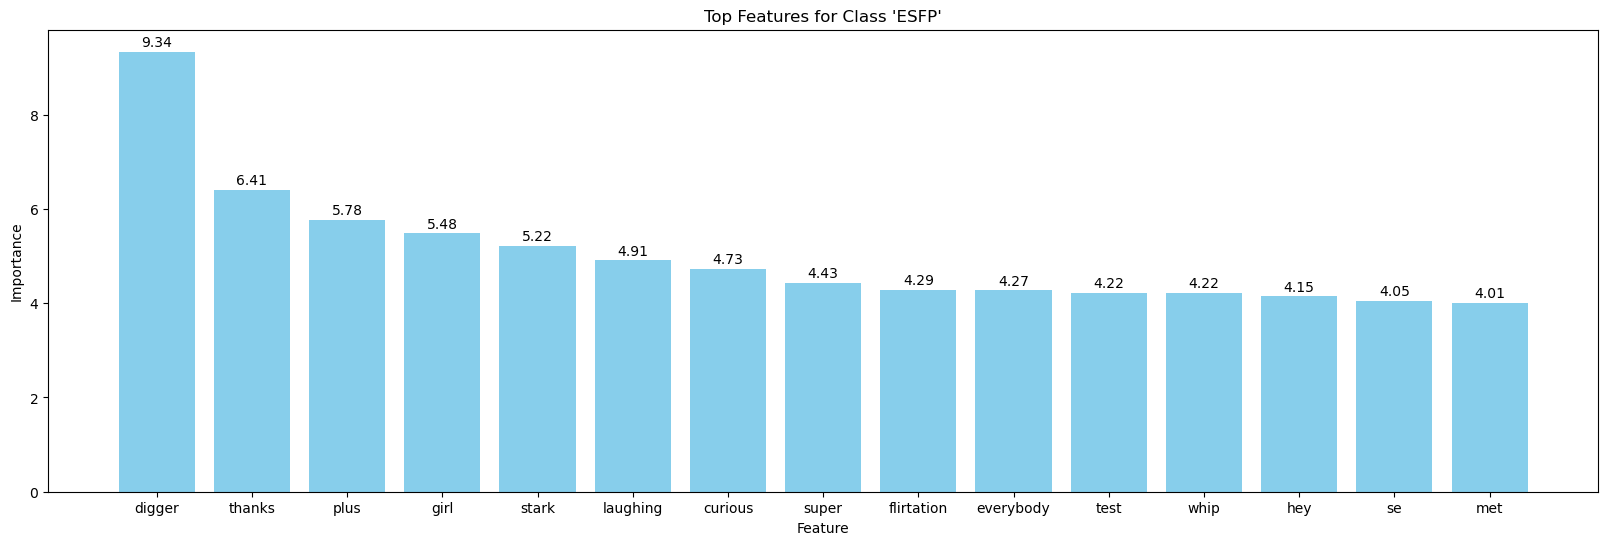

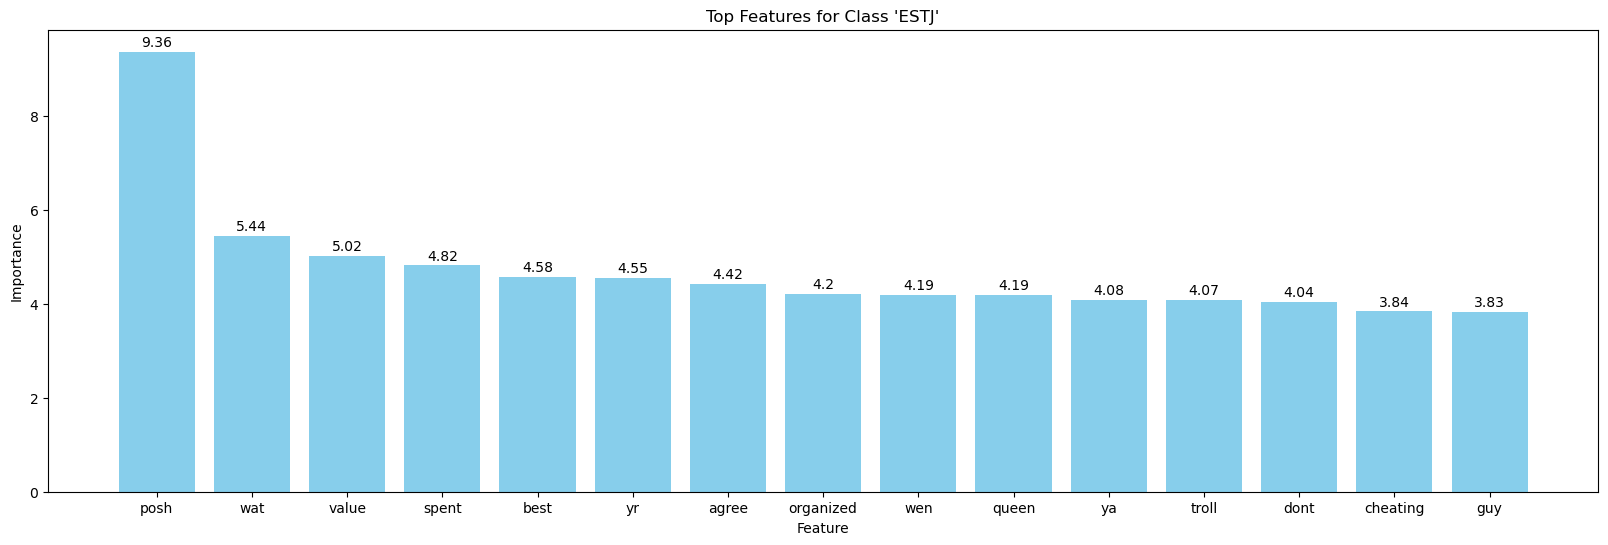

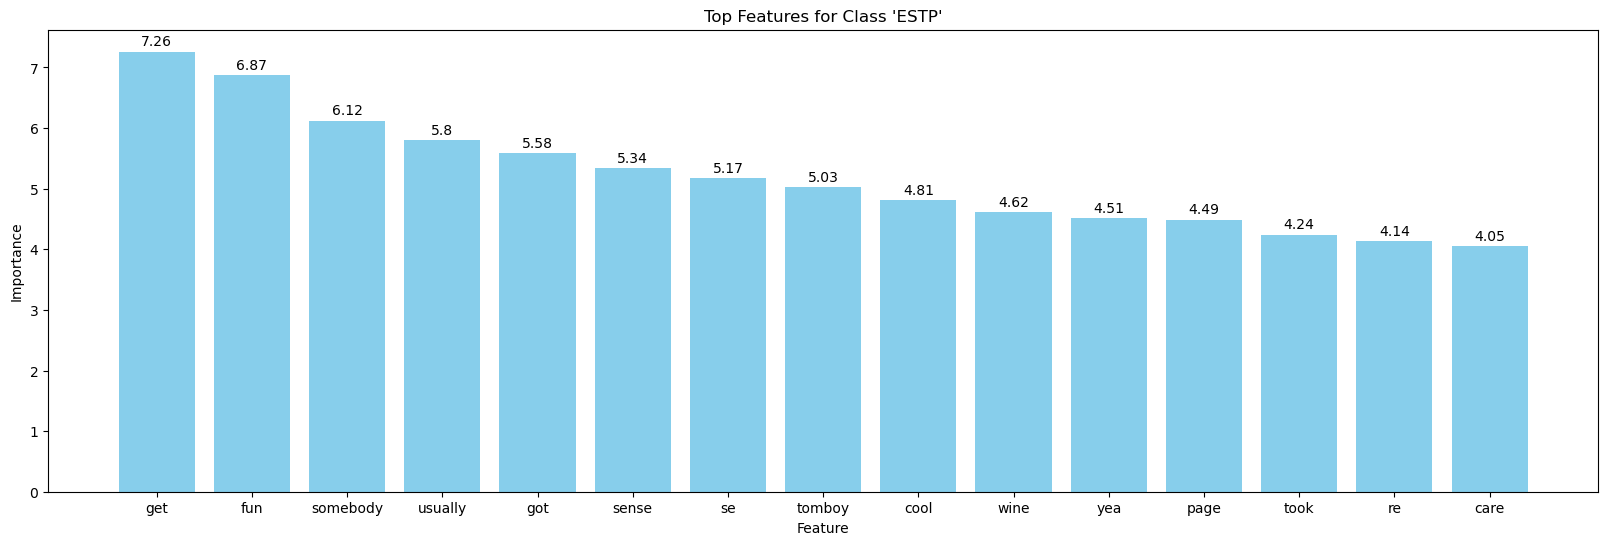

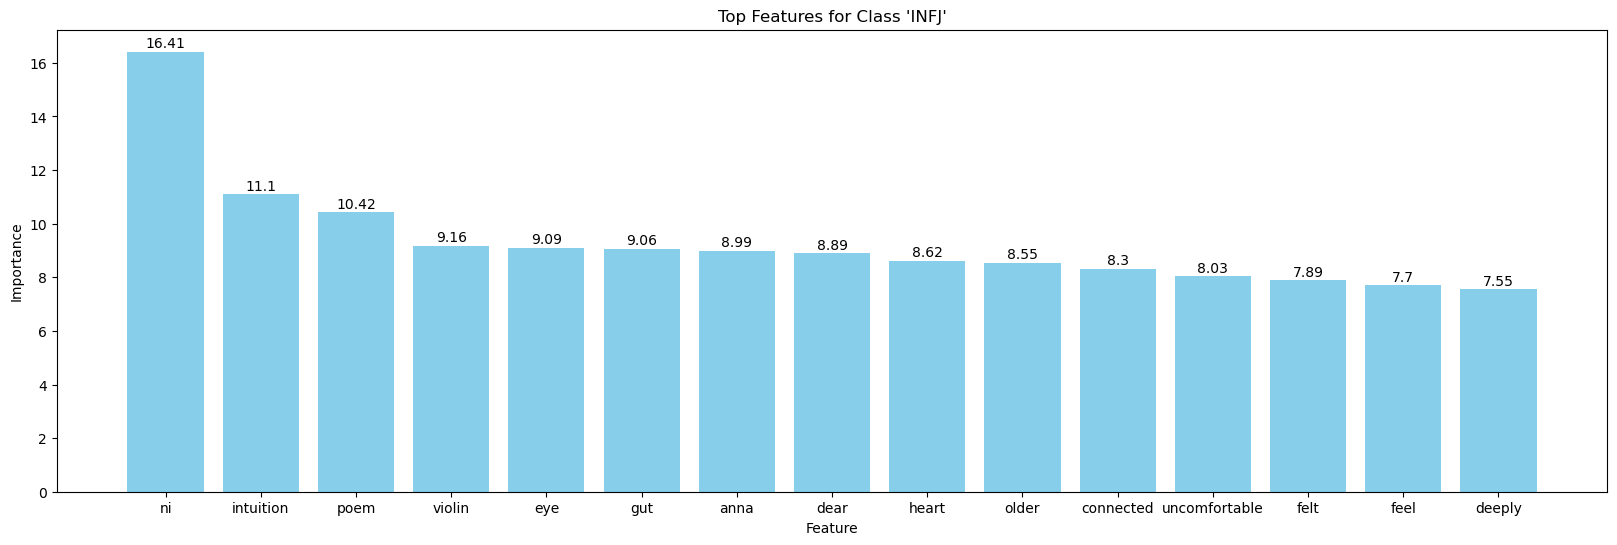

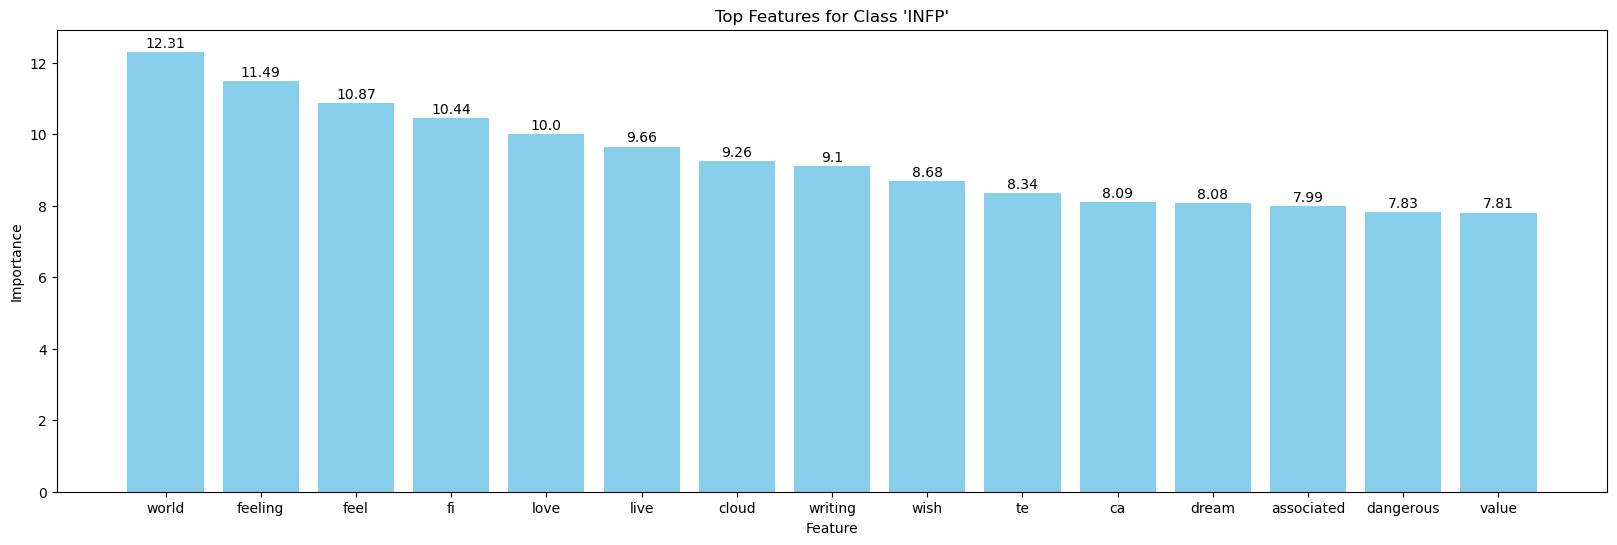

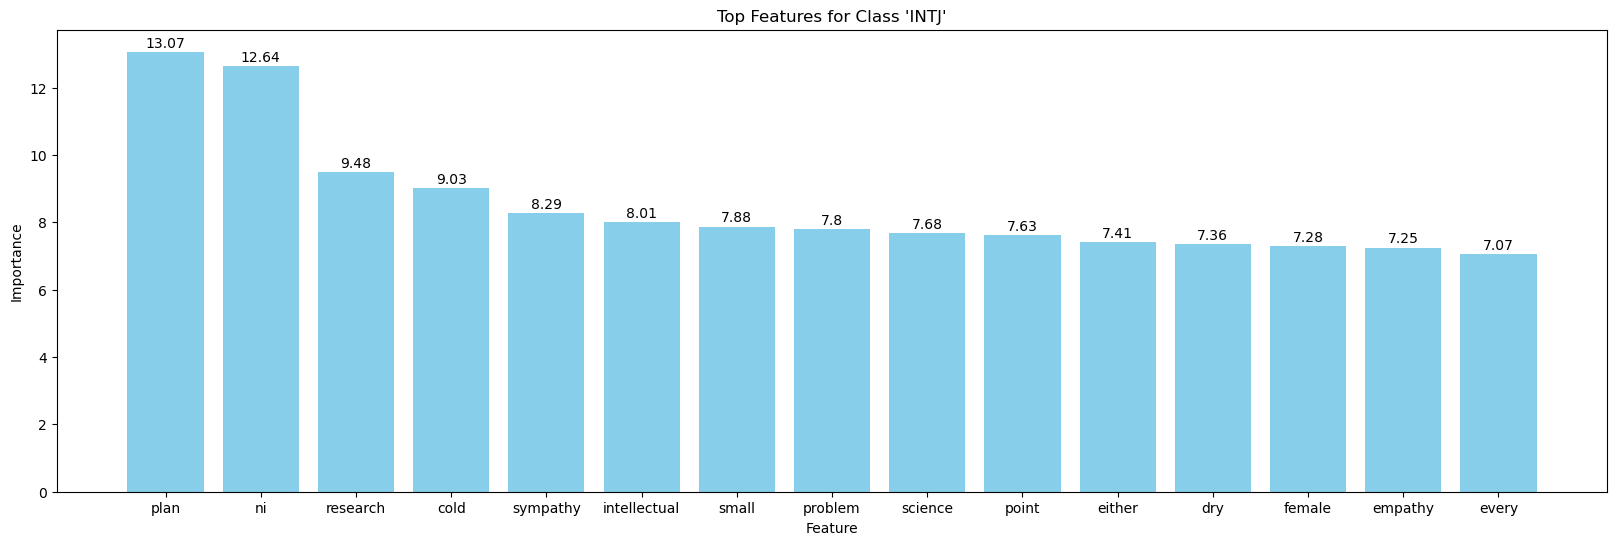

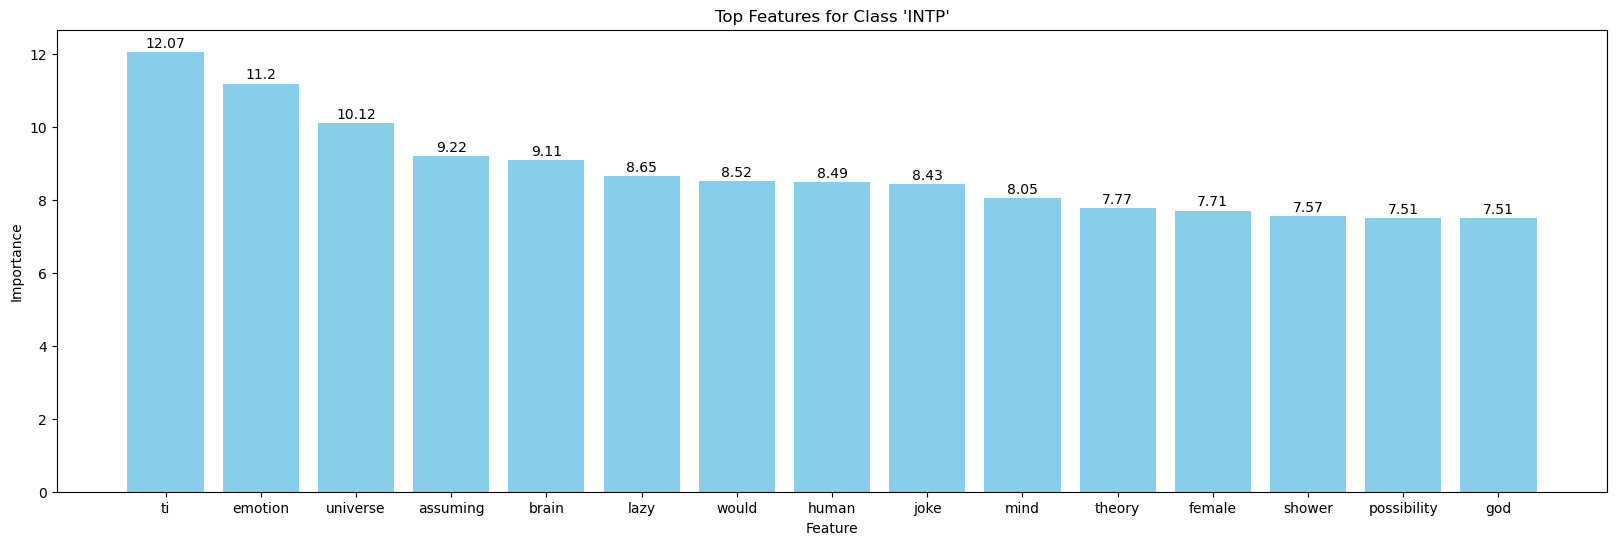

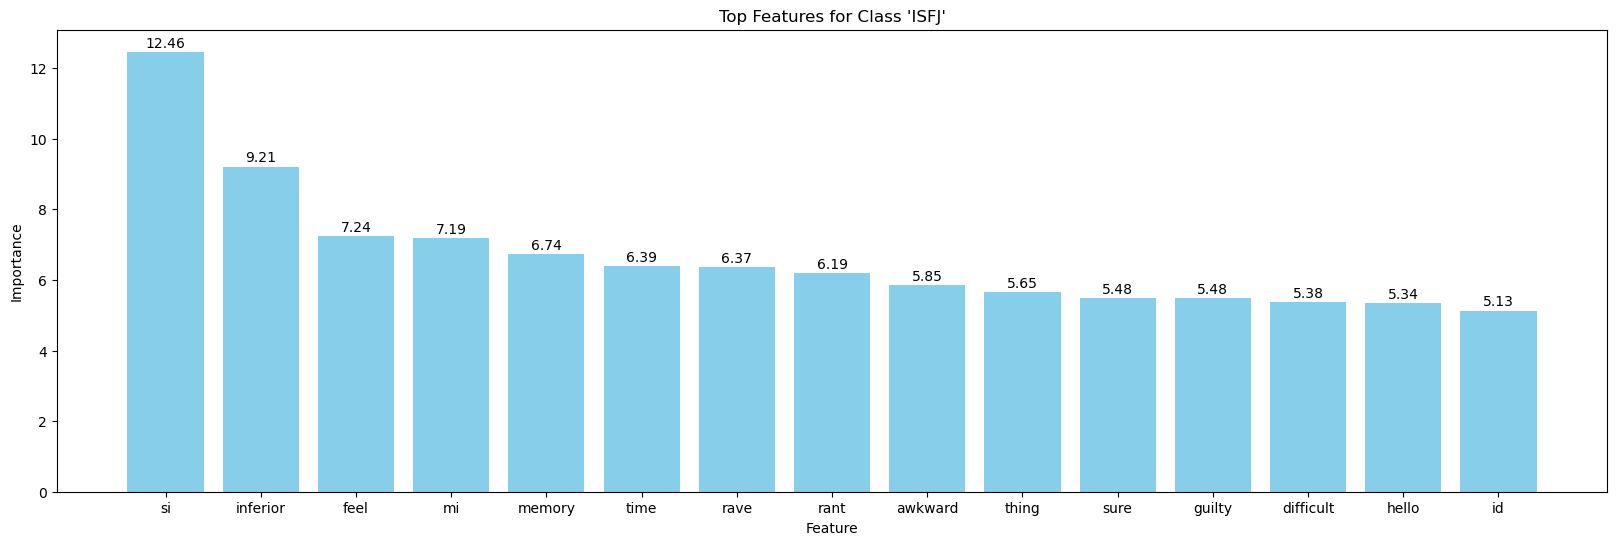

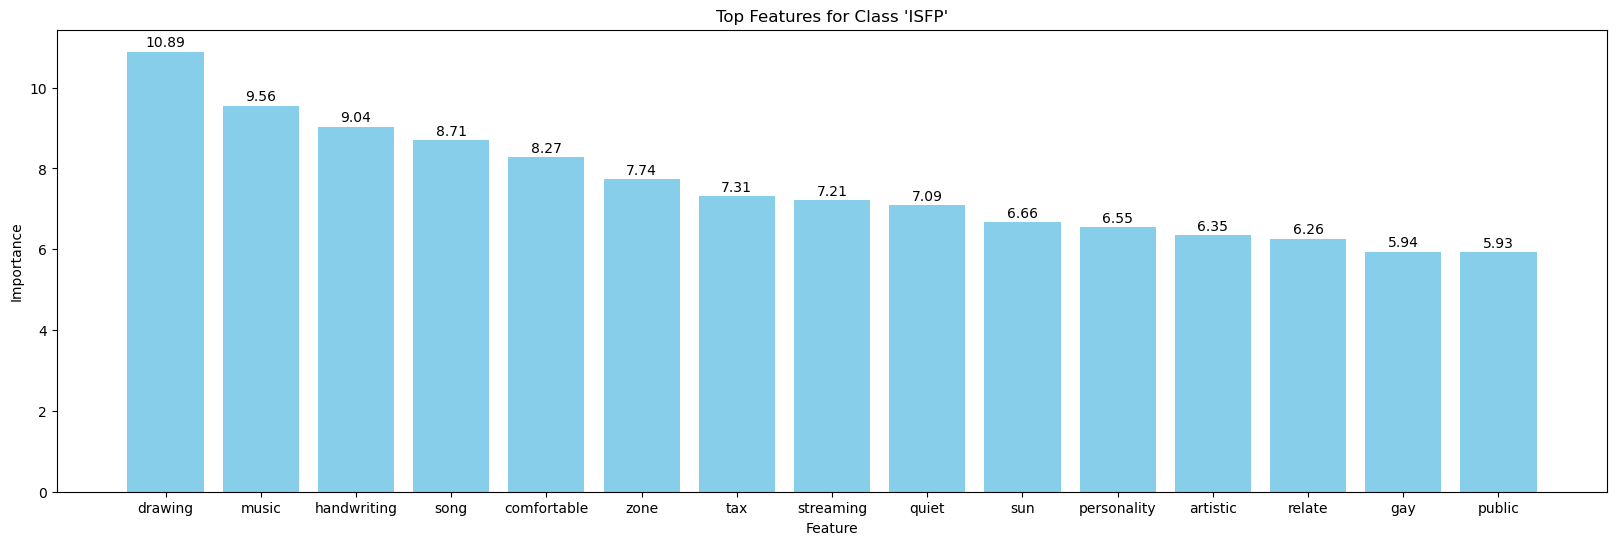

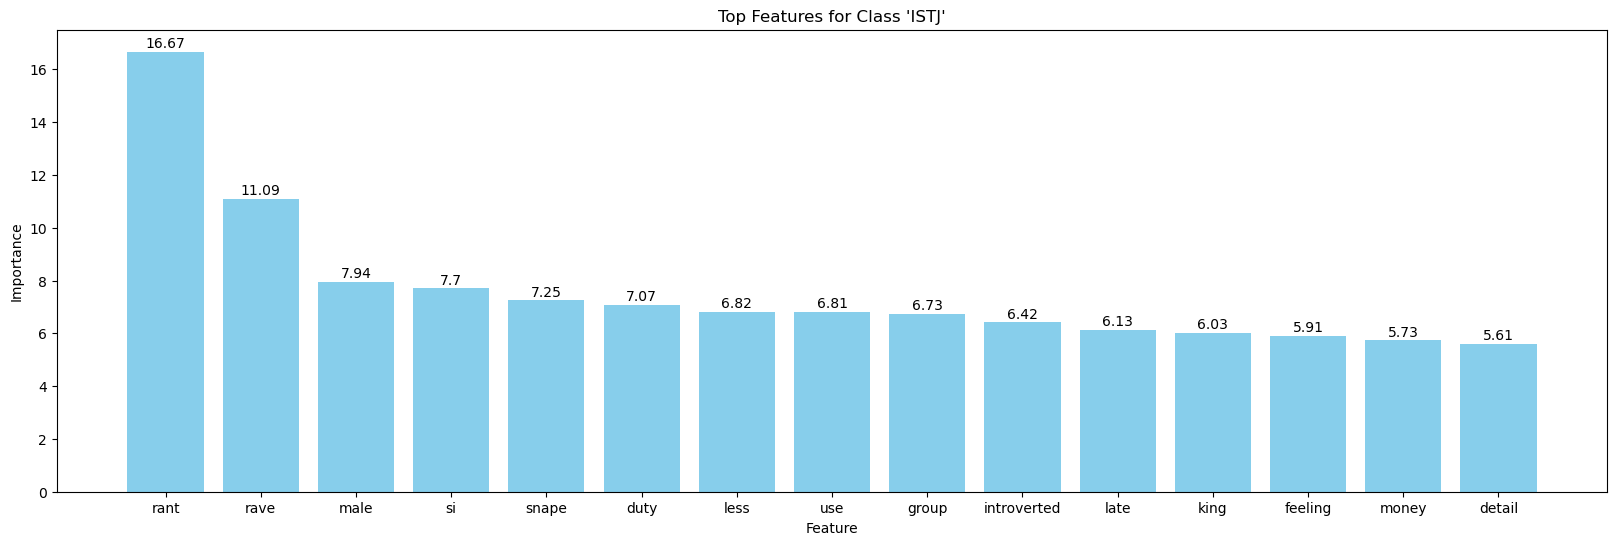

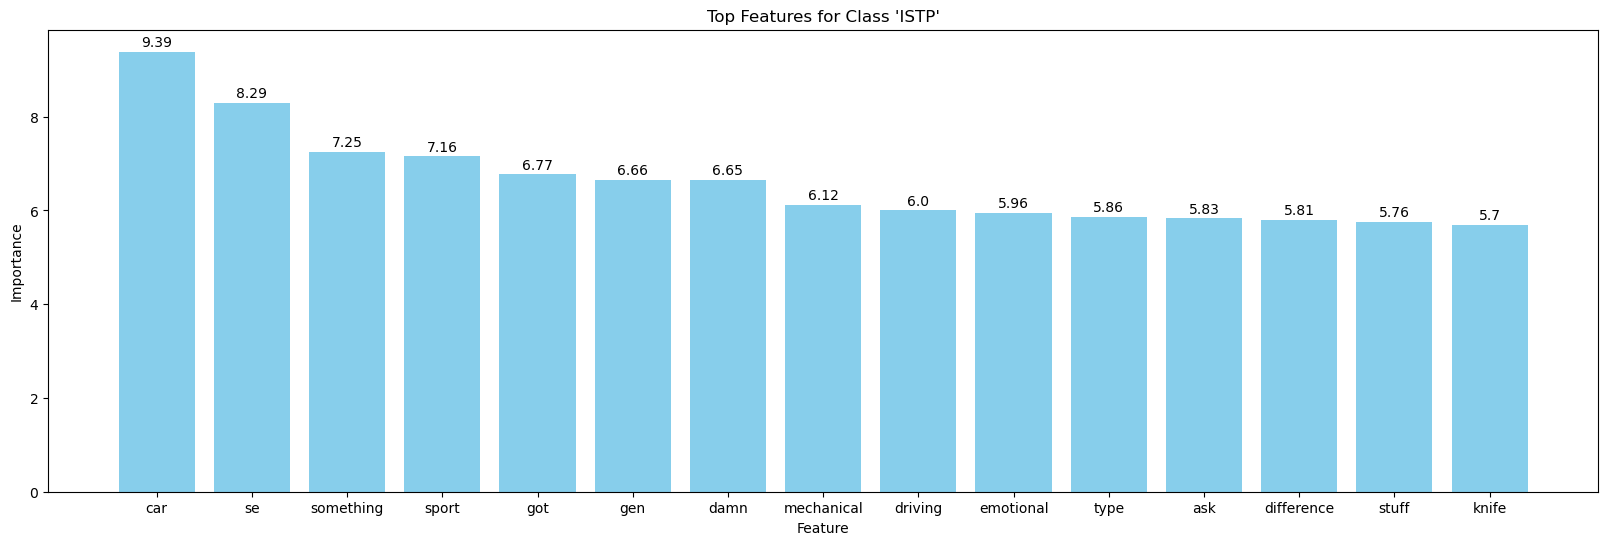

In [19]:
nltk.download('words')
english_words = set(nltk.corpus.words.words())

# only present english sentiment words
def is_english_word(word):
    return word.isalpha() and word.lower() in english_words

feature_names = tfidf_vectorizer.get_feature_names_out()
coefficients = model.coef_

for class_index in range(coefficients.shape[0]):
    class_coeffs = coefficients[class_index]
    sorted_indices = class_coeffs.argsort()[::-1]
    class_name = map_label[class_index]
    
    # Exclude label-specific features and filter non-English or meaningless words
    filtered_features = [(feature_names[i], class_coeffs[i]) for i in sorted_indices
                         if class_name.lower() not in feature_names[i].lower() and is_english_word(feature_names[i])]

    # Select the top 15 meaningful English words
    top_features = filtered_features[:15]
    features, importances = zip(*top_features)

    # Plotting
    plt.figure(figsize=(20, 6))
    bars = plt.bar(features, importances, color='skyblue')
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, round(yval, 2), ha='center', va='bottom')
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.title(f"Top Features for Class '{class_name}'")
    plt.show()

## 4.4: restore all feature importance for each label

In [20]:
for class_index in range(coefficients.shape[0]):
    class_coeffs = coefficients[class_index]
    sorted_indices = class_coeffs.argsort()[::-1]
    class_name = map_label[class_index]
    
    # Extract all features for this class
    all_features = [(feature_names[i], class_coeffs[i]) for i in sorted_indices]

    # Create DataFrame and save to CSV
    df = pd.DataFrame(all_features, columns=['Feature', 'Importance'])
    df.to_csv(f'output/all_features_for_{class_name}.csv', index=False)

    print(f"All features for class {class_name} saved to 'output/all_features_for_{class_name}.csv'")

All features for class ENFJ saved to 'output/all_features_for_ENFJ.csv'
All features for class ENFP saved to 'output/all_features_for_ENFP.csv'
All features for class ENTJ saved to 'output/all_features_for_ENTJ.csv'
All features for class ENTP saved to 'output/all_features_for_ENTP.csv'
All features for class ESFJ saved to 'output/all_features_for_ESFJ.csv'
All features for class ESFP saved to 'output/all_features_for_ESFP.csv'
All features for class ESTJ saved to 'output/all_features_for_ESTJ.csv'
All features for class ESTP saved to 'output/all_features_for_ESTP.csv'
All features for class INFJ saved to 'output/all_features_for_INFJ.csv'
All features for class INFP saved to 'output/all_features_for_INFP.csv'
All features for class INTJ saved to 'output/all_features_for_INTJ.csv'
All features for class INTP saved to 'output/all_features_for_INTP.csv'
All features for class ISFJ saved to 'output/all_features_for_ISFJ.csv'
All features for class ISFP saved to 'output/all_features_for_IS